In [ ]:
# Import the main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Import evaluation libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Using all the available descriptors

## Import the training set

In [ ]:
# Import the datasets 
dataset1=pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/training_data/alvadesc/API_alvadesc.csv') 
dataset2=pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/training_data/alvadesc/coformers_alvadesc.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,72,73,74,75,76,77,78,79,80,81,154,157,158,305,306,307,308,309,311,312,313,331,337,338,339,340,341,343,344,345,365,366,367,368,369,370,371,372,373,395,396,397,398,399,401,402,403,426,427,428,429,430,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,517,524,525,526,527,528,530,531,532,551,558,559,560,561,562,564,565,566,585,592,593,594,595,596,598,599,600,619,626,627,628,629,630,632,633,634,653,660,661,662,663,664,666,667,668,687,694,695,696,697,698,700,701,702,727,728,729,730,731,733,734,735,760,761,762,763,764,766,767,768,793,794,795,796,797,799,800,801,826,827,828,829,830,832,833,834,859,860,861,862,863,865,866,867,892,893,894,895,896,898,899,900,3842,3847,3848,3849,3855,3856,3857,3858,3871,3872,3873,3874,38

In [ ]:
all_molecules = np.concatenate([dataset1.Smiles1.values, dataset2.Smiles2.values])
keys, counts = np.unique(all_molecules, return_counts=True)
mols = pd.concat([pd.DataFrame(keys, columns=['name']), pd.DataFrame(counts, columns=['counts'])],axis=1)
mol = mols.sort_values(by=['counts'], ascending=False)
mol.head(10)

,name,counts
2992,c1cc(ccn1)c1ccncc1,271
1645,Fc1c(F)c(I)c(F)c(F)c1I,218
2984,c1cc(ccn1)C=Cc1ccncc1,153
1847,NC(=O)c1ccncc1,132
1728,N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N,122
2384,OC(=O)C=CC(O)=O,101
76,C(Cc1ccncc1)c1ccncc1,100
1866,NC(N)=O,86
1846,NC(=O)c1cccnc1,82
2416,OC(=O)CCC(O)=O,80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


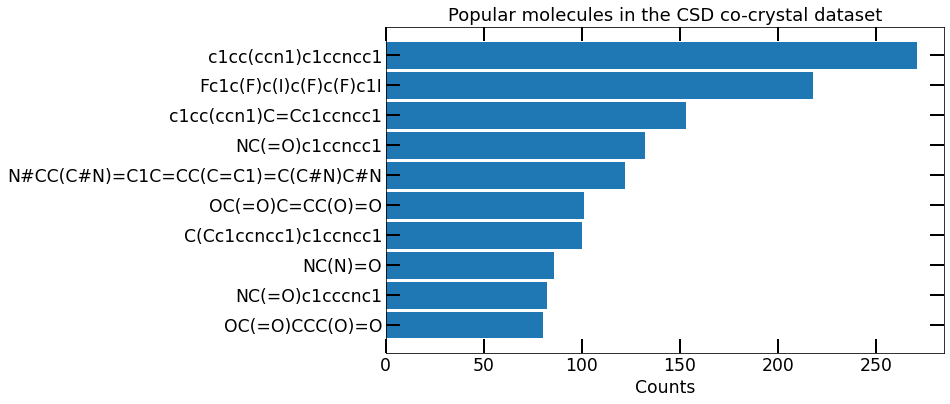

In [ ]:
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(mol.name.head(10).values, mol.counts.head(10).values, align='center', height= 0.9)
plt.gca().invert_yaxis()


ax.axis(aspect='equal')
ax.set(adjustable='box')#, aspect='equal')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.set_facecolor('xkcd:white')
ax.set_title('Popular molecules in the CSD co-crystal dataset', fontsize=18)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xlabel('Counts')
plt.savefig('count_popularity.png', bbox_inches='tight')
plt.show()

In [ ]:
df1=dataset1.iloc[:,2:]
#df1 = df1.fillna(0)
df2=dataset2.iloc[:,2:]
#df2 = df2.fillna(0)
#df1=df1.dropna(axis=1)
#df2=df2[df1.columns.values]
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1) #.fillna(0)
df2 = df2.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1) #.fillna(0)
columns_to_keep = [x for x in df1.columns.values if x in df2.columns.values]
print(df1.shape)
print(df2.shape)
print(len(columns_to_keep))

df2=df2[df1.columns.values]

(5522, 3612)
(5522, 3633)
3612


In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Entry'], dataset11, dataset22], axis=1), pd.concat([dataset1['Entry'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()


df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_concat = df_concat.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)
#df1_scaled = df1_scaled[df1_scaled.columns[df1_scaled.columns.isin(top_30)]]
#df2_scaled = df2_scaled[df2_scaled.columns[df2_scaled.columns.isin(top_30)]]

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)
print(df.shape)
df= df.drop_duplicates(subset=df.iloc[:, 1:].columns.values ,keep='last')
print(df.shape)

(11044, 7225)
(10618, 7225)


In [ ]:
#labelled = pd.concat([df1_scaled, df2_scaled], axis=1)
labelled = df.iloc[:5522, :]

## Import validation sets

In [ ]:
# First validation set from Richard Cooper paper : 'Will they co-crystalize?', where they performed experimental screening in 680 molecular pairs

rc_1=  pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/validation_data/RC_data/alvadesc/RCAPICCDCsmi.csv')
rc_2= pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/validation_data/RC_data/alvadesc/RCcoformerCCDCsmi.csv')
RC_data = pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/validation_data/RC_data/RCcocrystals_training .csv',  encoding='latin1')
rc_label = RC_data['Co-crystal']
rc1= rc_1.iloc[:,1:]
rc2= rc_2.iloc[:,2:]
rc1 = rc1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
rc2 = rc2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
rc1=rc1[df1.columns.values]
rc2=rc2[df1.columns.values]
rc_1_scaled = pd.DataFrame(X_scaler.transform(rc1), columns=df1.columns.values[:])
rc_2_scaled = pd.DataFrame(X_scaler.transform(rc2), columns=df1.columns.values[:])

rc_data=pd.concat([pd.DataFrame(rc_1.NAME.values, columns=['NAME1']) , rc_2.NAME ,rc_1_scaled, rc_2_scaled], axis =1)
rc_data=rc_data.dropna(axis=0)
rc_data#.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (309,336,337,338,339,340,342,343,344,399,430,457,458,459,460,461,463,464,465,731,764,797,830,863,896) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NAME1,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,...,F10[Cl-X],F10[Br-Br],F10[Br-I],F10[Br-B],F10[Br-Si],F10[Br-X],F10[I-I],F10[I-B],F10[I-Si],F10[I-X],F10[B-B],F10[B-Si],F10[B-X],F10[Si-Si],F10[Si-X],F10[X-X],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
0,NC(=O)c1cccnc1,OC(=O)c1ccccc1[N+](=O)[O-],0.031731,0.072642,0.040201,0.034504,0.038833,0.039443,0.251580,0.172454,0.129644,0.407321,0.479895,0.039409,0.043103,0.0625,0.041667,0.044444,0.066667,0.050279,0.033333,0.200000,0.076923,0.0,0.058252,0.053571,0.049505,0.111111,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493753,0.486696,0.122475,0.257298,0.194061,0.483562,0.014210,0.231502,0.083333,0.051941,0.051941,0.059989,0.0,1.0,1.0,0.8,0.8,0.333333,0.0,1.0,1.0,0.647416,0.666667,1.0
1,NC(=O)c1cccnc1,OC(=O)c1cccc(c1)[N+](=O)[O-],0.031731,0.072642,0.040201,0.034504,0.038833,0.039443,0.251580,0.172454,0.129644,0.407321,0.479895,0.039409,0.043103,0.0625,0.041667,0.044444,0.066667,0.050279,0.033333,0.200000,0.076923,0.0,0.058252,0.053571,0.049505,0.111111,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493753,0.486696,0.122475,0.257298,0.194061,0.483562,0.014210,0.231502,0.083333,0.051941,0.051941,0.059989,0.0,1.0,1.0,0.8,0.8,0.333333,0.0,1.0,1.0,0.647416,0.666667,1.0
2,NC(=O)c1cccnc1,OC(=O)c1ccc(cc1)[N+](=O)[O-],0.031731,0.072642,0.040201,0.034504,0.038833,0.039443,0.251580,0.172454,0.129644,0.407321,0.479895,0.039409,0.043103,0.0625,0.041667,0.044444,0.066667,0.050279,0.033333,0.200000,0.076923,0.0,0.058252,0.053571,0.049505,0.111111,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493753,0.486696,0.122475,0.257298,0.194061,0.483562,0.014210,0.231502,0.083333,0.051941,0.051941,0.059989,0.0,1.0,1.0,0.8,0.8,0.333333,0.0,1.0,1.0,0.647416,0.666667,1.0
3,NC(=O)c1cccnc1,OC(=O)c1ccccc1O,0.031731,0.072642,0.040201,0.034504,0.038833,0.039443,0.251580,0.172454,0.129644,0.407321,0.479895,0.039409,0.043103,0.0625,0.041667,0.044444,0.066667,0.050279,0.033333,0.200000,0.076923,0.0,0.058252,0.053571,0.049505,0.111111,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445903,0.402541,0.214258,0.178084,0.134315,0.483925,0.014358,0.215759,0.166667,0.042584,0.042584,0.047935,0.0,1.0,1.0,0.8,0.8,0.555556,0.0,1.0,1.0,0.683891,1.000000,1.0
4,NC(=O)c1cccnc1,OC(=O)c1cccc(O)c1,0.031731,0.072642,0.040201,0.034504,0.038833,0.039443,0.251580,0.172454,0.129644,0.407321,0.479895,0.039409,0.043103,0.0625,0.041667,0.044444,0.066667,0.050279,0.033333,0.200000,0.076923,0.0,0.058252,0.053571,0.049505,0.111111,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445903,0.402541,0.214258,0.178084,0.134315,0.462077,0.006816,0.215759,0.166667,0.042584,0.042584,0.047935,0.0,1.0,1.0,0.8,0.8,0.555556,0.0,1.0,1.0,0.683891,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,CC1=CC2=C(C=C1C)N(CC(O)C(O)C(O)CO)C1=NC(=O)NC(...,COC1=CC=CC=C1C(N)=O,0.161719,0.069742,0.184059,0.194784,0.172640,0.196431,0.214248,0.205445,0.100417,0.419480,0.131677,0.197044,0.198276,0.2500,0.199074,0.192593,0.095238,0.178771,0.166667,0.306122,0.307692,0.0,0.058252,0.178571,0.158416,0.222222,0.171429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.638298,.

In [ ]:
# Second validation set: Publically available data from 

public_1=  pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/public_available_data/APICCDCsmi.csv')
public_2= pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/public_available_data/coformerCCDCsmi.csv')
public_data = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/public_available_data/PublicallyAvalibledata.csv', encoding='latin1')
grecu_label = public_data['Co-crystal']

#Scale the negatives based on the potitives
pub1= public_1.iloc[:,1:]
pub2= public_2.iloc[:,1:]
#pub1 = pub1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
#pub2 = pub2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

pub1=pub1[df1.columns.values]
pub2=pub2[df1.columns.values]

public_1_scaled = pd.DataFrame(X_scaler.transform(pub1), columns=df1.columns.values[:])
public_2_scaled = pd.DataFrame(X_scaler.transform(pub2), columns=df1.columns.values[:])

#public_1_scaled = public_1_scaled[public_1_scaled.columns[public_1_scaled.columns.isin(top_30)]]
#public_2_scaled = public_2_scaled[public_2_scaled.columns[public_2_scaled.columns.isin(top_30)]]

grecu=pd.concat([ pd.DataFrame(public_1.NAME.values, columns=['NAME1']) , public_2.NAME ,public_1_scaled, public_2_scaled], axis =1)
grecu.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (156) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (304,305,306,307,308,309,310,311,312,394,395,396,397,398,399,400,401,402,425,426,427,428,429,430,431,432,433,523,524,525,526,527,529,530,531,557,558,559,560,561,563,564,565,591,592,593,594,595,597,598,599,625,626,627,628,629,631,632,633,659,660,661,662,663,665,666,667,693,694,695,696,697,699,700,701,731,764,797,830,863,896) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NAME1,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,...,F10[Cl-X],F10[Br-Br],F10[Br-I],F10[Br-B],F10[Br-Si],F10[Br-X],F10[I-I],F10[I-B],F10[I-Si],F10[I-X],F10[B-B],F10[B-Si],F10[B-X],F10[Si-Si],F10[Si-X],F10[X-X],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
0,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,COc1ccc(cc1)C1=NN2C=C(C)N=C2S1,0.120694,0.110086,0.123526,0.109017,0.121131,0.109311,0.334997,0.183614,0.199463,0.329663,0.203114,0.1133,0.12931,0.125,0.115741,0.125926,0.12381,0.128492,0.133333,0.387097,0.076923,0.0,0.116505,0.098214,0.128713,0.055556,0.057143,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.142857,0.1,0.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594537,0.535257,0.037529,0.122024,0.157966,0.503566,0.023507,0.086779,0.000000,0.103088,0.103088,0.096172,0.0,1.0,1.0,1.0,1.0,0.555556,0.0,1.0,1.0,0.744681,0.666667,1.0
1,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,CC1=NN2C=C(C)N=C2S1,0.120694,0.110086,0.123526,0.109017,0.121131,0.109311,0.334997,0.183614,0.199463,0.329663,0.203114,0.1133,0.12931,0.125,0.115741,0.125926,0.12381,0.128492,0.133333,0.387097,0.076923,0.0,0.116505,0.098214,0.128713,0.055556,0.057143,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.142857,0.1,0.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493753,0.426379,0.051786,0.093453,0.136417,0.445879,0.003018,0.065304,0.000000,0.049089,0.049089,0.038952,0.0,1.0,1.0,0.6,0.8,0.777778,0.5,1.0,1.0,0.781155,1.000000,1.0
2,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,c1cc(ccn1)c1ccncc1,0.120694,0.110086,0.123526,0.109017,0.121131,0.109311,0.334997,0.183614,0.199463,0.329663,0.203114,0.1133,0.12931,0.125,0.115741,0.125926,0.12381,0.128492,0.133333,0.387097,0.076923,0.0,0.116505,0.098214,0.128713,0.055556,0.057143,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.142857,0.1,0.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550012,0.486696,0.023317,0.079802,0.060189,0.457010,0.005464,0.065543,0.000000,0.062968,0.062968,0.061282,0.0,1.0,1.0,0.8,0.8,0.555556,0.0,1.0,1.0,0.683891,1.000000,1.0
3,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,NC1=CN=CC=C1,0.120694,0.110086,0.123526,0.109017,0.121131,0.109311,0.334997,0.183614,0.199463,0.329663,0.203114,0.1133,0.12931,0.125,0.115741,0.125926,0.12381,0.128492,0.133333,0.387097,0.076923,0.0,0.116505,0.098214,0.128713,0.055556,0.057143,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.142857,0.1,0.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.243901,0.120446,0.090843,0.407488,0.000111,0.096999,0.064227,0.025140,0.025140,0.022400,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0
4,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,Nc1ccccn1,0.120694,0.110086,0.123526,0.109017,0.121131,0.109311,0.334997,0.183614,0.199463,0.329663,0.203114,0.1133,0.12931,0.125,0.115741,0.125926,0.12381,0.128492,0.133333,0.387097,0.076923,0.0,0.116505,0.098214,0.128713,0.055556,0.057143,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.142857,0.1,0.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.243901,0.120446,0.090843,0.442205,0.002369,0.096999,0.064227,0.025140,0.025140,0.022400,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0


In [ ]:
# Third validation set: Artemisin

artemicin_1=  pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/validation_data/Artemisin/alvadesc/artemisininAPIalvadesc.csv')
artemicin_2= pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/validation_data/Artemisin/alvadesc/artemisininCoformersalvadesc.csv')
artemicin_data = pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/validation_data/Artemisin/artemisinin.csv')
artemicin_label = artemicin_data['Cocrystal']
#Scale the negatives based on the potitives
art1= artemicin_1.iloc[:,1:]
art2= artemicin_2.iloc[:,1:]

art1=art1[df1.columns.values]
art2=art2[df1.columns.values]
artem_1_scaled = pd.DataFrame(X_scaler.transform(art1), columns=df1.columns.values[:])
artem_2_scaled = pd.DataFrame(X_scaler.transform(art2), columns=df1.columns.values[:])
artemicin=pd.concat([artemicin_1.NAME, artemicin_2.NAME ,artem_1_scaled, artem_2_scaled], axis =1)
artemicin.head()

,NAME,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,...,F10[Cl-X],F10[Br-Br],F10[Br-I],F10[Br-B],F10[Br-Si],F10[Br-X],F10[I-I],F10[I-B],F10[I-Si],F10[I-X],F10[B-B],F10[B-Si],F10[B-X],F10[Si-Si],F10[Si-X],F10[X-X],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
0,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,OC1=CC2=CC=CC=C2C(=C1)O,0.113644,0.041905,0.14609,0.165362,0.144378,0.170834,0.139161,0.137518,0.077552,0.401054,0.21163,0.172414,0.137931,0.125,0.180556,0.148148,0.009524,0.111732,0.0,0.0,0.076923,0.0,0.0,0.196429,0.138614,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.785714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.532849,0.468161,0.185478,0.125244,0.094462,0.500215,0.021787,0.166667,0.166667,0.059792,0.059792,0.060031,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0
1,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,NC1=CC(=CC=C1)N,0.113644,0.041905,0.14609,0.165362,0.144378,0.170834,0.139161,0.137518,0.077552,0.401054,0.21163,0.172414,0.137931,0.125,0.180556,0.148148,0.009524,0.111732,0.0,0.0,0.076923,0.0,0.0,0.196429,0.138614,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.785714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.496060,0.161090,0.121498,0.451856,0.004242,0.128454,0.128454,0.036556,0.036556,0.034559,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,0.833333,1.0
2,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,NC1=CC(=CC(=C1)N)C(O)=O,0.113644,0.041905,0.14609,0.165362,0.144378,0.170834,0.139161,0.137518,0.077552,0.401054,0.21163,0.172414,0.137931,0.125,0.180556,0.148148,0.009524,0.111732,0.0,0.0,0.076923,0.0,0.0,0.196429,0.138614,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.785714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445903,0.402541,0.586877,0.276552,0.208582,0.438997,0.001866,0.260880,0.211788,0.053999,0.053999,0.057219,0.0,1.0,1.0,0.8,0.8,0.555556,0.0,1.0,1.0,0.683891,0.500000,1.0
3,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,NC1=CC=CC(=C1)O,0.113644,0.041905,0.14609,0.165362,0.144378,0.170834,0.139161,0.137518,0.077552,0.401054,0.21163,0.172414,0.137931,0.125,0.180556,0.148148,0.009524,0.111732,0.0,0.0,0.076923,0.0,0.0,0.196429,0.138614,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.785714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.354529,0.143167,0.107980,0.451856,0.004242,0.147561,0.147561,0.033226,0.033226,0.033006,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0
4,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,NC1=CC(=C(O)C=C1)C(O)=O,0.113644,0.041905,0.14609,0.165362,0.144378,0.170834,0.139161,0.137518,0.077552,0.401054,0.21163,0.172414,0.137931,0.125,0.180556,0.148148,0.009524,0.111732,0.0,0.0,0.076923,0.0,0.0,0.196429,0.138614,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.785714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445903,0.402541,0.452165,0.258629,0.195064,0.460845,0.006474,0.279986,0.230894,0.050669,0.050669,0.055666,0.0,1.0,1.0,0.8,0.8,0.555556,0.0,1.0,1.0,0.683891,0.500000,1.0


## Import the unlabelled dataset from ZINC15


In [ ]:
# Generate the unknown dataset (unlabelled)

# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/data_complete/test_data/zinc15_unlabel_dataset_AlvaDesc.csv')
val = unlabeled['NAME'].values
length = len(val)
pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

In [ ]:
pairs = pd.DataFrame(no_dups)
keys = unlabeled['NAME'].values
values = unlabeled.iloc[:, 1:].values
d = {key:value for key, value in zip(keys, values)}

In [ ]:
mol1_data= list()

for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 1:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 1:].columns.values) 

In [ ]:
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(0)
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

unlab=pd.concat([pairs[0], pairs[1]], axis=1)
final_1 = final_1.replace({'#NUM!': 0})
final_2 = final_2.replace({'#NUM!': 0})

final_11 = final_1
final_22 =final_2

In [ ]:
final_11 = final_11.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
final_22 = final_22.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
final_11=final_11[df1.columns.values]
final_22=final_22[df1.columns.values]

In [ ]:
# Standarize the unlabeled data based on the labelled
final_1_scaled = pd.DataFrame(X_scaler.transform(final_11.iloc[:,:]), columns= df1.columns.values[:])
final_2_scaled = pd.DataFrame(X_scaler.transform(final_22.iloc[:,:]),columns= df1.columns.values[:])
uf=pd.concat([final_1_scaled, final_2_scaled], axis =1)

## Deep One Class Architecture

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/MyDrive/ccdc_ml_cocrystals/models/deep_one_class
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

# Could also add a plot showing the train and validation loss 

/content/drive/MyDrive/ccdc_ml_cocrystals/models/deep_one_class
/content/drive/MyDrive/ccdc_ml_cocrystals/models/deep_one_class/src/set_transformer
/content/drive/MyDrive/ccdc_ml_cocrystals/models/deep_one_class/src


In [ ]:
class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if train:
          # Setup the train dataset
          # labelled.iloc[:,1:]
          self.data=data.values.astype('f')
          self.labels=np.zeros(self.data.shape[0])

        else:
          # Setup the test dataset
          self.data = rc_data.iloc[:,2:].values.astype('f')# public.values.astype('f')
          self.labels = np.abs(rc_label.values - 1)
         
    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=3612, dim_out=2000, num_heads=5),
              SAB(dim_in=2000, dim_out=1000, num_heads=5),
            SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=5),)#
        self.is_pretrain = True
        self.pma = nn.Sequential(PMA(dim=100, num_heads=5, num_seeds=1),
                                 SAB(dim_in=100, dim_out=50, num_heads=10))#,
                                # nn.Linear(50, 10))
        
    def forward(self, inp):
      x = torch.split(inp, 3612, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x)

      if self.is_pretrain:
        return x

      x = self.pma(x)
      return x.squeeze()

class PairsAutoEncoder(BaseNet):
    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( PMA(dim=100, num_heads=5, num_seeds=1),
            SAB(dim_in=100, dim_out=200, num_heads=5),
            SAB(dim_in=200, dim_out=2000, num_heads=5),
            nn.Linear(in_features=2000, out_features=7224), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x)).squeeze()

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
  return PairsEncoder()

torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 50, 
              'ae_lr': 0.00001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 1e-06,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': 0, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
dataset_name = cfg.settings['dataset_name']
#data_path = cfg.settings['data_path']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
#xp_path = cfg.settings['xp_path']
df=df.fillna(0)
dataset = Pairs_Dataset('', data= labelled.iloc[:, 1:] )

In [ ]:
def set_seed():
  seed = cfg.settings.get('seed', 0)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
set_seed()
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#lr=1e-4, n_epochs = 100 batch_size=100,
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-4,
                   n_epochs =  32, #90
                   lr_milestones=(200,),
                   batch_size= 100, #32
                   weight_decay=1e-06,   #-06
                   device=device,
                   n_jobs_dataloader=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/32	 Time: 74.545	 Loss: 447.39704118
INFO:root:  Epoch 2/32	 Time: 73.866	 Loss: 59.58383090
INFO:root:  Epoch 3/32	 Time: 73.419	 Loss: 47.95028543
INFO:root

In [ ]:
auc= deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,   #lr=1e-5
                   n_epochs = 150 , #100,
                   lr_milestones=(100,),
                   batch_size=32, #150
                   weight_decay=1e-05,
                   device=device,
                   n_jobs_dataloader=0)

nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
INFO:root:Starting pretraining...
Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
INFO:root:  Epoch 1/150	 Time: 4.219	 Loss: 446.38692854
INFO:root:  Epoch 2/150	 Time: 4.128	 Loss: 69.97269676
INFO:root:  Epoch 3/150	 Time: 4.100	 Loss: 56.99304883
INFO:root:  Epoch 4/150	 Time: 4.121	 Loss: 50.79439302
INFO:root:  Epoch 5/150	 Time: 4.244	 Loss: 46.53333225
INFO:root:  Epoch 6/150	 Time: 4.272	 Loss: 42.80481343
INFO:root:  Epoch 7/150	 Time: 4.268	 Loss: 39.09659109
INFO:root:  Epoch 8/150	 Time: 4.227	 Loss: 36.47856910
INFO:root:  Epoch 9/150	 Time: 4.244	 Loss: 34.29651537
INFO:r

In [ ]:
auc= deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,   #lr=1e-5
                   n_epochs = 250 , #100,
                   lr_milestones=(100,),
                   batch_size=150, #150
                   weight_decay=1e-01,
                   device=device,
                   n_jobs_dataloader=0)

nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
INFO:root:Starting pretraining...
Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
INFO:root:  Epoch 1/250	 Time: 1.679	 Loss: 1368.16842239
INFO:root:  Epoch 2/250	 Time: 1.658	 Loss: 383.66325317
INFO:root:  Epoch 3/250	 Time: 1.653	 Loss: 99.39946169
INFO:root:  Epoch 4/250	 Time: 1.664	 Loss: 82.52858239
INFO:root:  Epoch 5/250	 Time: 1.660	 Loss: 75.67043428
INFO:root:  Epoch 6/250	 Time: 1.655	 Loss: 70.02003005
INFO:root:  Epoch 7/250	 Time: 1.651	 Loss: 65.53509233
INFO:root:  Epoch 8/250	 Time: 1.651	 Loss: 61.61902763
INFO:root:  Epoch 9/250	 Time: 1.653	 Loss: 58.92618117
INFO

In [ ]:
deep_SVDD.net.is_pretrain = False

In [ ]:
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,  #160
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size= 100 ,#cfg.settings['batch_size'],  50
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 60.942	 Loss: 0.02411683
INFO:root:  Epoch 2/60	 Time: 61.857	 Loss: 0.00381568
INFO:root:  Epoch 3/60	 Time: 61.759	 Loss: 0.00243882
INFO:root:  Epoch 4/60	 Time: 61.400	 Loss: 0.00183579
INFO:root:  Epoch 5/60	 Time: 60.580	 Loss: 0.00142652
INFO:root:  Epoch 6/60	 Time: 61.036	 Loss: 0.00121226
INFO:root:  Epoch 7/6

In [ ]:
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 160,  
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size= 100 ,#cfg.settings['batch_size'],  50
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Starting training...
Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
INFO:root:  Epoch 1/160	 Time: 1.524	 Loss: 0.00173034
INFO:root:  Epoch 2/160	 Time: 1.515	 Loss: 0.00002268
INFO:root:  Epoch 3/160	 Time: 1.520	 Loss: 0.00001225
INFO:root:  Epoch 4/160	 Time: 1.529	 Loss: 0.00000997
INFO:root:  Epoch 5/160	 Time: 1.530	 Loss: 0.00000881
INFO:root:  Epoch 6/160	 Time: 1.507	 Loss: 0.00000842
INFO:root:  Epoch 7/160	 Time: 1.529	 Loss: 0.00000824
INFO:root:  Epoch 8/160	 Time: 1.518	 Loss: 0.00000786
INFO:root:  Epoch 9/160	 Time: 1.542	 Loss: 0.00000780
INFO:root:  Epoch 10/160	 Time: 1.513	 Loss: 0.00000806
INFO:root:  Epoch 11/160	 Time: 1.520	 Lo

In [ ]:
deep_SVDD.test(dataset)

INFO:root:Starting testing...
INFO:root:Testing time: 2.032
INFO:root:Test set AUC: 66.25%
INFO:root:Finished testing.


In [ ]:
# Save the deepSVDD model
#pth_path = ('/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/model_checkpoint_final.pth') 
#deep_SVDD.save_model(pth_path)

## Scoring 

The scoring is performed based on the distance of the center of the hypersphere. Herein, as we want a ranking between [0,1], the scores of the neural net are multiplied by -1 and normalized to [0,1] to be comparable with the standrard models.\
The scores disribution is visualized for both the labeled and unlabeled datasets.

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
from optim.ae_trainer import nakius_score

In [ ]:
def ae_score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.ae_net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        #print(y.dim(), y.shape, X.shape)
        scores = nakius_score(X, y)#torch.sum((y - X) ** 2, dim=tuple(range(1, y.dim())))
    return scores

In [ ]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()
lab = ae_score(deep_SVDD, labelled.iloc[:, 1:].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
#uf_final= uf_final.fillna(0)
#unlab = score(deep_SVDD, uf_final.iloc[:,2:].values).cpu().detach().numpy()*-1
#unlab = y_scaler1.transform(unlab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
#unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)

In [ ]:
#lab=pd.DataFrame(np.array(lab_list).ravel(), columns=['train_score'])
print(lab.shape)
lab.describe()
#lab[lab.train_score<0.75]

(5522, 1)


,train_score
count,5522.000000
mean,0.925366
std,0.058201
min,0.000000
25%,0.904360
50%,0.939401
75%,0.963179
max,1.000000


In [ ]:
#uf_final= uf_final.fillna(0)
unlab = score(deep_SVDD, uf.iloc[:,:].values).cpu().detach().numpy()*-1
unlab = y_scaler1.transform(unlab.reshape(-1,1))
unlab_final=pd.DataFrame(unlab, columns=['test_score'] )
#pd.concat([uf['id'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)
unlab_final.describe()

,test_score
count,22791.000000
mean,-11.780019
std,76.519859
min,-1129.937988
25%,-1.514101
50%,-0.604845
75%,-0.095827
max,0.815589


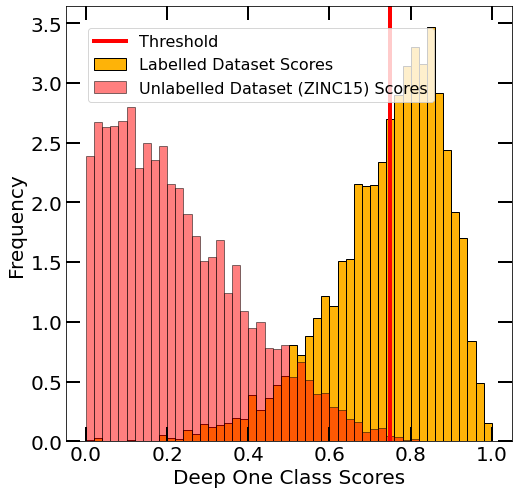

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(lab.train_score.values, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')
#_= plt.hist(validation.score, bins=150,density=True, ec='k',alpha=0.5, color='red', label='Paracetamol Validation Scores')
_= plt.hist(unlab_final.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset (ZINC15) Scores')
#_= plt.hist(unlab_final_drug.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Drug Subset Scores')
#_= plt.hist(val.train_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset Scores')
_ = plt.axvline(x=0.75, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
#major_ticks_x = np.arange(0, 1.001, 0.2)
#minor_ticks_x = np.arange(0,1.001, 0.1)
#major_ticks_y = np.arange(0, 6, 2)
#minor_ticks_y = np.arange(0, 6, 1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)

plt.legend(prop={'size': 16}, loc=[0.05, 0.78])
#plt.savefig('/content/alva.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

## Evaluation 

In [ ]:
# RC data
api_list= rc_data[['NAME1']].drop_duplicates(['NAME1']).values.ravel()
for i in api_list[:]:

  mc_df = rc_data[rc_data['NAME1']==i]
  score_mc = -1*score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  #score_mc = clf.decision_function(mc_df.iloc[:,2:].values)*-1
  true_label = rc_label.loc[mc_df.index]
  roc_auc_mc = roc_auc_score(true_label, score_mc)
  print(i, roc_auc_mc)

NC(=O)c1cccnc1 0.7571428571428571
NC(=O)c1ccncc1 0.4731182795698925
c1cc(ccn1)c1ccncc1 0.5310344827586206
OC(=O)C=CC(O)=O 0.513888888888889
OC(=O)c1ccccc1O 0.5607142857142857
NC(N)=O 0.6923076923076924
NC(=O)c1ccccc1 0.7125
OC(=O)C(O)=O 0.6785714285714287
Oc1ccc(O)cc1 0.43223443223443225
O=C1CCCN1 0.34523809523809523
CN1C=NC2=C1C(=O)N(C)C(=O)N2C 0.6912280701754386
CCCCCCCC(O)=O 0.171875
NC(CCC(O)=O)C(O)=O 0.5528846153846154
OC(=O)C1=CN=CC=C1 0.6977777777777778
CC1=NC=C(CO)C(=C1O)CO 0.5925925925925926
OC(=O)CCSCCC(O)=O 0.4083333333333333
OC(CC(O)=O)C(O)=O 0.575
OC(=O)CC(=CC(O)=O)C(O)=O 0.65
OCC(O)C1OC(=O)C(=C1O)O 0.6
CC1=CC2=C(C=C1C)N(CC(O)C(O)C(O)CO)C1=NC(=O)NC(=O)C1=N2 0.8125


In [ ]:
# Evalute on the RC data
roc_auc = roc_auc_score(rc_label.values[:-1], -1*ae_score(deep_SVDD, rc_data.iloc[:,2:].values).cpu().detach().numpy())
print('RC', roc_auc)
# Evaluate on the Grecu data
#roc_auc = roc_auc_score(public_label.iloc[public2.index].values, -1*ae_score(deep_SVDD, public2.iloc[:,2:].values).cpu().detach().numpy())
roc_auc = roc_auc_score(grecu_label.values, -1*ae_score(deep_SVDD, grecu.iloc[:,2:].values).cpu().detach().numpy())
print('Grecu', roc_auc)

RC 0.6482511923688394
Grecu 0.5513289304123712


In [ ]:
from sklearn.preprocessing import MinMaxScaler

test_scaler = MinMaxScaler()

In [ ]:
# Grecu data validation

pub = -1*ae_score(deep_SVDD, rc_data.iloc[:,2:].values).cpu().detach().numpy()
pub1 = X_scaler.fit_transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(rc_label.values[:-1], columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

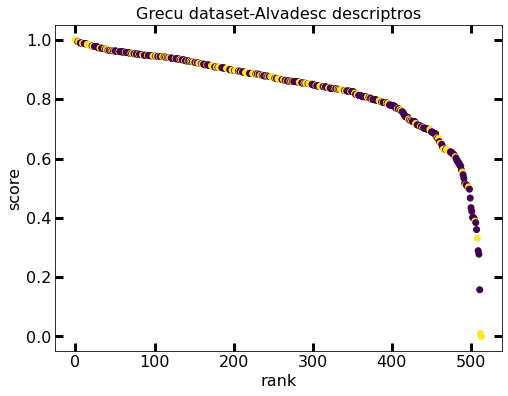

In [ ]:

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
x=np.arange(len(pub))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color)
plt.title('Grecu data validation set')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xlabel('rank', fontsize=16)
plt.title('Grecu dataset-Alvadesc descriptros', fontsize=16)
plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/grecu_alva_colorplot.png', dpi=600)





0.5513289304123712


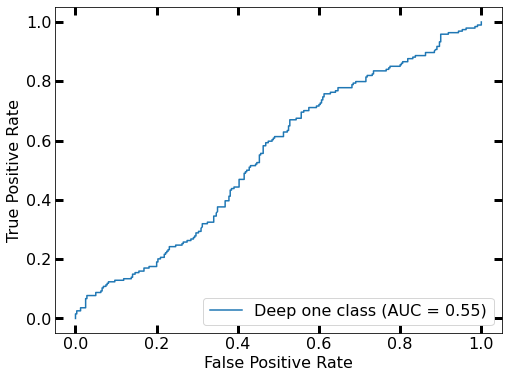

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
roc_auc = roc_auc_score(grecu_label.values[:], -1*ae_score(deep_SVDD, grecu.iloc[:,2:].values).cpu().detach().numpy())

print(roc_auc)
fpr, tpr, _ = roc_curve(grecu_label.values[:], -1*ae_score(deep_SVDD, grecu.iloc[:,2:].values).cpu().detach().numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Deep one class').plot(ax=ax)
plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/grecu_alva_auc.png', dpi=600)

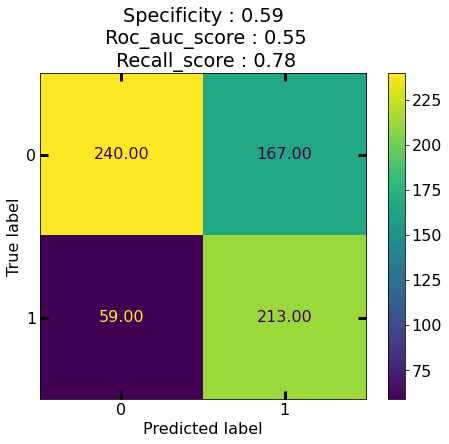

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Public available

y_pred  =[1 if i>=0.8 else 0 for i in pub_val_sort.score.values]
y_test = rc_label.values[:-1]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
#roc_auc = roc_auc_score(y_test, predicted_scores)
recall=recall_score(y_test, y_pred)
ax.set_title('Specificity : ' + str(round(specificity,2)) +
             '\n Roc_auc_score : '+ str(round(roc_auc,2)) +
             '\n Recall_score : ' +  str(round(recall,2)) )
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=(0,1)).plot(ax=ax, values_format='.2f')
plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/rc_alva_confusion_matrix.png', bbox_inches='tight' ,dpi=600)

In [ ]:
# Public data validation

pub = -1*ae_score(deep_SVDD, artemicin.iloc[:,2:].values).cpu().detach().numpy()

pub_validation=pd.concat([pd.DataFrame(pub, columns=['score']), pd.DataFrame(artemicin_label.values, columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

Text(0.5, 1.0, 'Artemisin validation set')

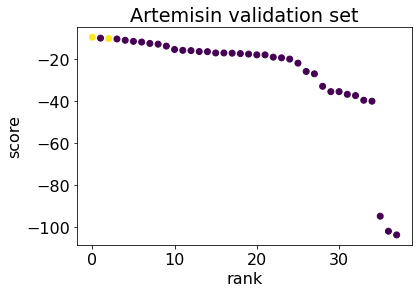

In [ ]:
x=np.arange(len(pub))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color)
#plt.ylim(-100,0)
#plt.axhline(y=0.9, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')
plt.title('Artemisin validation set')


Artemisin validation 1.0


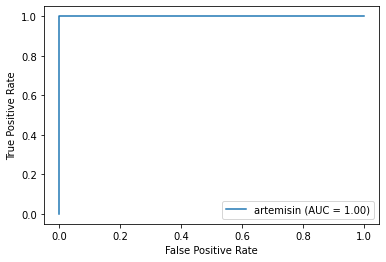

In [ ]:
roc_auc = roc_auc_score(artemicin_label, -1*score(deep_SVDD, artemicin.iloc[:,:].values).cpu().detach().numpy())
print('Artemisin validation', roc_auc)
fpr, tpr, _ = roc_curve(artemicin_label, -1*score(deep_SVDD, artemicin.iloc[:,:].values).cpu().detach().numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='artemisin').plot()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score


def plot_apis(api):
  #fig, (ax1, ax2) = plt.subplots(2)
  test = grecu[grecu['Name 1']==i]
  test_label = grecu_label.iloc[test.index]
  rc = ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy()*-1
  rc1 = X_scaler.fit_transform(rc.reshape(-1,1))
  rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(test_label.values, columns=['color'])], axis=1)
  rc_val_sort = rc_validation.sort_values(by='score', ascending=False)
  x=np.arange(len(rc1))
  #ax2.scatter(x ,rc_val_sort.score, c=rc_val_sort.color, cmap='viridis')
  #plt.ylim(0,1)
  #plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
  #ax2.ylabel('score')
  #ax2.xlabel('rank')
  #ax2.title('%s'%api)
  
  roc_auc = roc_auc_score(test_label, -1*ae_score(deep_SVDD,test.iloc[:,2:].values).cpu().detach().numpy())
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='%s'%i).plot()
  plt.show()

In [ ]:
def plot_apis(api):

  test = grecu[grecu.NAME1 == api]
  test_label =grecu_label.iloc[test.index]
  rc = ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy()*-1
  rc1 = y_scaler1.fit_transform(rc.reshape(-1,1))
  rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(test_label.values, columns=['color'])], axis=1)
  rc_val_sort = rc_validation.sort_values(by='score', ascending=False)
  x=np.arange(len(rc1))
  plt.scatter(x ,rc_val_sort.score, c=rc_val_sort.color, cmap='viridis')
  #plt.ylim(0,1)
  #plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
  plt.ylabel('score')
  plt.xlabel('rank')
  #plt.title('%s'%api)
  plt.show()


OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl 0.8571428571428571


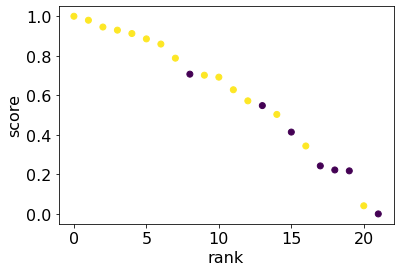

NC(=O)CN1CCCC1=O 0.8052631578947368


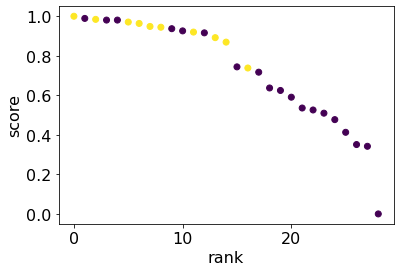

NC(=O)c1cnccn1 0.7357142857142858


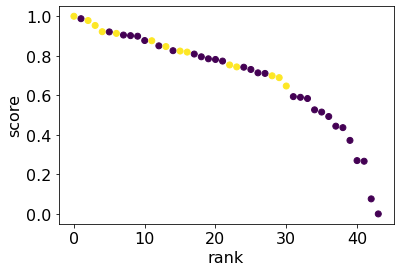

CC(=O)Nc1nnc(s1)S(N)(=O)=O 0.7555555555555555


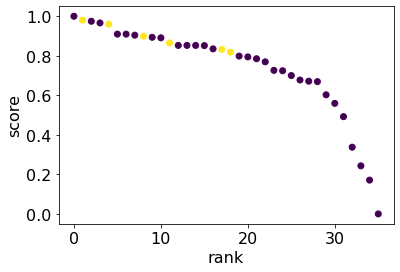

COc1ccc2c(c1)c(CC(O)=O)c(C)n2C(=O)c1ccc(Cl)cc1 0.6018518518518519


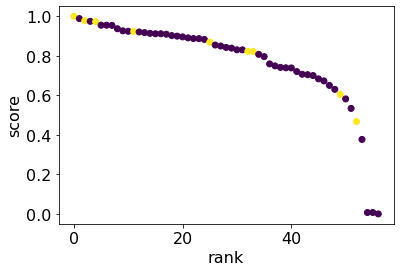

CCC(F)(F)c1cc(nc2SC(=C(N)c12)C(N)=O)N1CCC(CC1)S(C)(=O)=O 0.91156462585034


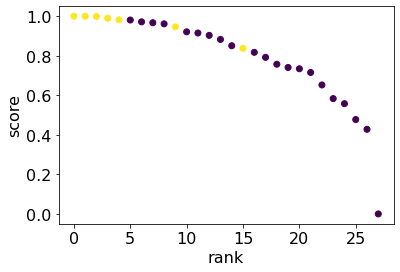

NS(=O)(=O)c1cc(C(O)=O)c(NCc2ccco2)cc1Cl 0.64375


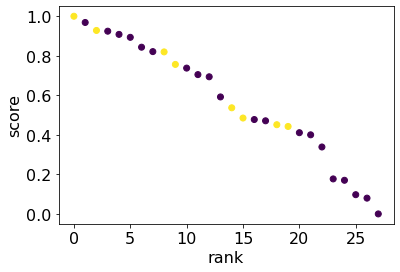

CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12 0.7395833333333334


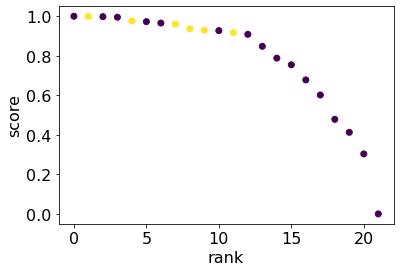

CC(=O)Nc1ccc(O)cc1 0.34970238095238093


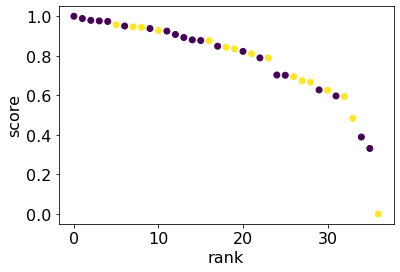

OC1=CC=CC(=C1)C#N 0.9111111111111112


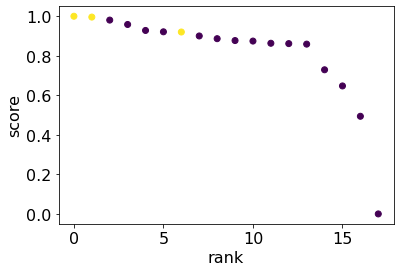

OC1=CC=C(C=C1)C#N 0.9821428571428572


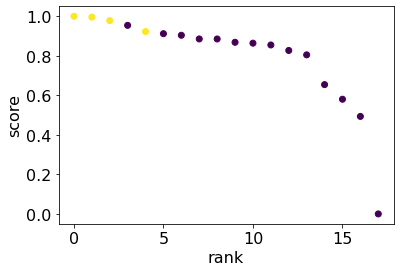

N#CC1=CN=CC=C1 0.7058823529411764


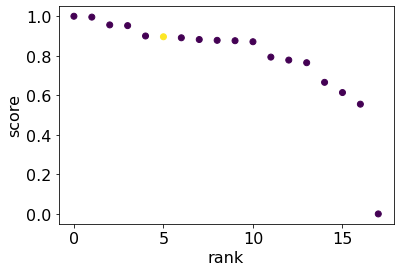

N#CC1=CC=NC=C1 0.48888888888888893


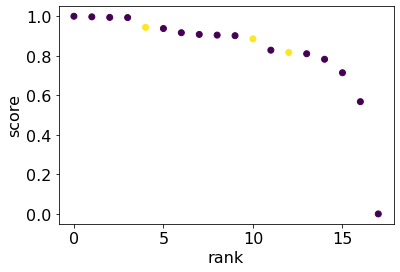

NC(=O)C1=CC=CC=C1 0.8


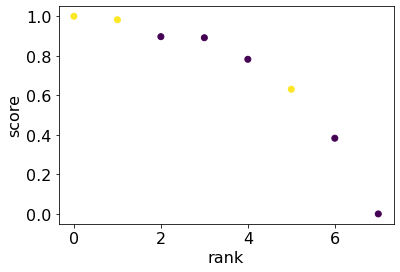

CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC=C(OCC2COC(CN3C=NC=N3)(O2)C2=C(Cl)C=C(Cl)C=C2)C=C1 0.84375


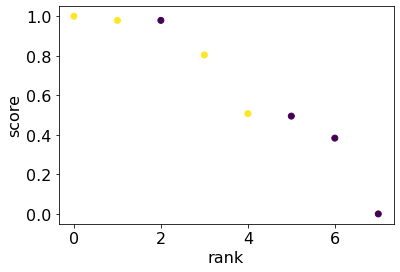

CC(O)(CS(=O)(=O)C1=CC=C(F)C=C1)C(=O)NC1=CC(=C(C=C1)C#N)C(F)(F)F 0.96875


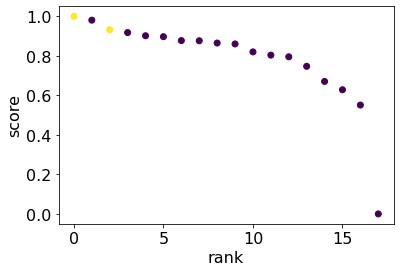

CN1C(=C(O)C2=CC=CC=C2S1(=O)=O)C(=O)NC1=NC=C(C)S1 0.9285714285714286


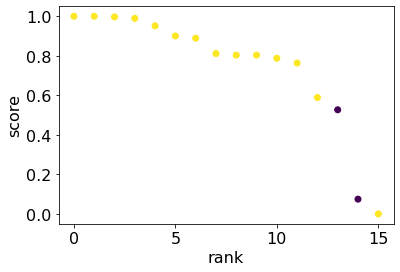

NC(=O)c1cccnc1 0.8333333333333334


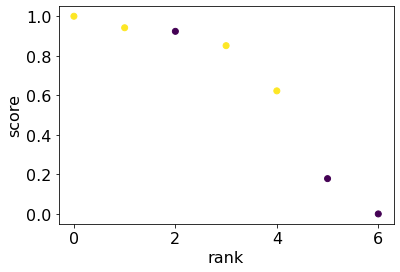

CCOC(=O)N1CCC(CC1)=C1C2=C(CCC3=C1N=CC=C3)C=C(Cl)C=C2 0.7290322580645162


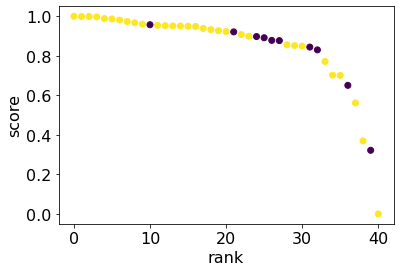

ClC1=CC2=C(C=C1)C(=C1CCNCC1)C1=C(CC2)C=CC=N1 0.6491596638655462


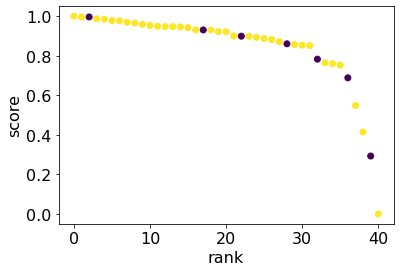

In [ ]:
api_list= grecu[['NAME1']].drop_duplicates(['NAME1']).values.ravel()

for i in api_list[:]:
  mc_df =grecu[grecu['NAME1']==i]
  score_mc = -1*ae_score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  #score_mc = clf.decision_function(mc_df.iloc[:,2:].values)*-1
  true_label = grecu_label.loc[mc_df.index]
  roc_auc_mc = roc_auc_score(true_label, score_mc)
  print(i, roc_auc_mc)
  plot_apis(i)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score


def plot_apis(api):
  #fig, (ax1, ax2) = plt.subplots(2)
  test = public[public['Name 1']==i]
  test_label = public_label.iloc[test.index]
  rc = ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy()*-1
  rc1 = X_scaler.fit_transform(rc.reshape(-1,1))
  rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(test_label.values, columns=['color'])], axis=1)
  rc_val_sort = rc_validation.sort_values(by='score', ascending=False)
  x=np.arange(len(rc1))
  #ax2.scatter(x ,rc_val_sort.score, c=rc_val_sort.color, cmap='viridis')
  #plt.ylim(0,1)
  #plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
  #ax2.ylabel('score')
  #ax2.xlabel('rank')
  #ax2.title('%s'%api)
  
  roc_auc = roc_auc_score(test_label, -1*ae_score(deep_SVDD,test.iloc[:,2:].values).cpu().detach().numpy())
 
  fpr, tpr, _ = roc_curve(test_label, -1*ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy())
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='%s'%i).plot()
  

In [ ]:
# Evaluate per API
api_list=public[['NAME1']].drop_duplicates(['NAME1']).values.ravel()

for i in api_list[:]:
  mc_df =public[public['NAME1']==i]
  score_mc = -1*score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  #score_mc = clf.decision_function(mc_df.iloc[:,2:].values)*-1
  true_label = public_label.loc[mc_df.index]
  try:
    roc_auc_mc = roc_auc_score(true_label, score_mc)
    print(i, roc_auc_mc)
    plot_apis(i)
  except:
    pass

OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl 0.9619047619047619
NC(=O)CN1CCCC1=O 0.9368421052631579
NC(=O)c1cnccn1 0.8547619047619048
CC(=O)Nc1nnc(s1)S(N)(=O)=O 0.9555555555555556
COc1ccc2c(c1)c(CC(O)=O)c(C)n2C(=O)c1ccc(Cl)cc1 0.6736111111111112
CCC(F)(F)c1cc(nc2SC(=C(N)c12)C(N)=O)N1CCC(CC1)S(C)(=O)=O 0.7891156462585034
NS(=O)(=O)c1cc(C(O)=O)c(NCc2ccco2)cc1Cl 0.725
CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12 0.9895833333333334
CC(=O)Nc1ccc(O)cc1 0.5669642857142857
OC1=CC=CC(=C1)C#N 1.0
OC1=CC=C(C=C1)C#N 0.9821428571428572
N#CC1=CN=CC=C1 1.0
N#CC1=CC=NC=C1 1.0
NC(=O)C1=CC=CC=C1 0.8
CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC=C(OCC2COC(CN3C=NC=N3)(O2)C2=C(Cl)C=C(Cl)C=C2)C=C1 0.46875
CC(O)(CS(=O)(=O)C1=CC=C(F)C=C1)C(=O)NC1=CC(=C(C=C1)C#N)C(F)(F)F 1.0
CN1C(=C(O)C2=CC=CC=C2S1(=O)=O)C(=O)NC1=NC=C(C)S1 0.9285714285714286
NC(=O)c1cccnc1 0.7500000000000001
CCOC(=O)N1CCC(CC1)=C1C2=C(CCC3=C1N=CC=C3)C=C(Cl)C=C2 0.7967741935483871
ClC1=CC2=C(C=C1)C(=C1CCNCC1)C1=C(CC2)C=CC=N1 0.7710084033613445


In [ ]:

nalixidic = public[public.NAME1 == 'CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12']
nalixidic_label = public_label.loc[nalixidic.index]
nalixidic 

,NAME1,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,...,F10[Cl-X],F10[Br-Br],F10[Br-I],F10[Br-B],F10[Br-Si],F10[Br-X],F10[I-I],F10[I-B],F10[I-Si],F10[I-X],F10[B-B],F10[B-Si],F10[B-X],F10[Si-Si],F10[Si-X],F10[X-X],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
244,CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12,Oc1cc(O)cc(O)c1,0.088027,0.069747,0.105738,0.103688,0.100796,0.106752,0.24386,0.175326,0.125431,0.38288,0.23514,0.108374,0.112069,0.15625,0.111111,0.111111,0.085714,0.111732,0.066667,0.2,0.230769,0.0,0.058252,0.107143,0.108911,0.111111,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.62069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.348099,0.187866,0.141693,0.427580,0.000563,0.250000,0.250000,0.034652,0.034652,0.037631,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,0.833333,1.0
245,CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12,Oc1cccc(O)c1,0.088027,0.069747,0.105738,0.103688,0.100796,0.106752,0.24386,0.175326,0.125431,0.38288,0.23514,0.108374,0.112069,0.15625,0.111111,0.111111,0.085714,0.111732,0.066667,0.2,0.230769,0.0,0.058252,0.107143,0.108911,0.111111,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.62069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.226917,0.125244,0.094462,0.451856,0.004242,0.166667,0.166667,0.029896,0.029896,0.031453,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0
246,CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12,CC1=CC(=CC(=C1)O)O,0.088027,0.069747,0.105738,0.103688,0.100796,0.106752,0.24386,0.175326,0.125431,0.38288,0.23514,0.108374,0.112069,0.15625,0.111111,0.111111,0.085714,0.111732,0.066667,0.2,0.230769,0.0,0.058252,0.107143,0.108911,0.111111,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.62069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.213433,0.125244,0.094462,0.466958,0.008260,0.166667,0.166667,0.041312,0.041312,0.043612,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0
247,CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12,Oc1ccc(O)cc1,0.088027,0.069747,0.105738,0.103688,0.100796,0.106752,0.24386,0.175326,0.125431,0.38288,0.23514,0.108374,0.112069,0.15625,0.111111,0.111111,0.085714,0.111732,0.066667,0.2,0.230769,0.0,0.058252,0.107143,0.108911,0.111111,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.62069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.226917,0.125244,0.094462,0.451856,0.004242,0.166667,0.166667,0.029896,0.029896,0.031453,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0
248,CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12,Oc1cccc(O)c1O,0.088027,0.069747,0.105738,0.103688,0.100796,0.106752,0.24386,0.175326,0.125431,0.38288,0.23514,0.108374,0.112069,0.15625,0.111111,0.111111,0.085714,0.111732,0.066667,0.2,0.230769,0.0,0.058252,0.107143,0.108911,0.111111,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.62069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.348099,0.187866,0.141693,0.427580,0.000563,0.250000,0.250000,0.034652,0.034652,0.037631,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,0.833333,1.0
249,CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12,Oc1ccccc1O,0.088027,0.069747,0.105738,0.103688,0.100796,0.106752,0.24386,0.175326,0.125431,0.38288,0.23514,0.108374,0.112069,0.15625,0.111111,0.111111,0.085714,0.111732,0.066667,0.2,0.230769,0.0,0.058252,0.107143,0.108911,0.111111,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.62069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417269,0.346730,0.226917,0.125244,0.094462,0.451856,0.004242,0.166667,0.166667,0.029896,0.029896,0.031453,0.0,1.0,1.0,0.6,0.8,0.555556,0.0,1.0,1.0,0.653495,1.000000,1.0
250,CCN1C=C(C(O)=O)C(=O)c2ccc(C)nc12,COc1cc(C=CC(O)=O)ccc1O,0.088027,0.069747,0.105738,0.103688,0.100796,0.1

In [ ]:

diclophenac = public[public.NAME1 == 'OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl']
diclophenac_label = public_label.loc[diclophenac.index]

In [ ]:
paracetamol = public[public.NAME1 == 'CC(=O)Nc1ccc(O)cc1']
paracetamol_label = public_label.loc[paracetamol.index]

In [ ]:
itraconazole =public[public.NAME1 == 'CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC=C(OCC2COC(CN3C=NC=N3)(O2)C2=C(Cl)C=C(Cl)C=C2)C=C1']
itraconazole_label = public_label.loc[itraconazole.index]
itraconazole

,NAME1,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,...,F10[Cl-X],F10[Br-Br],F10[Br-I],F10[Br-B],F10[Br-Si],F10[Br-X],F10[I-I],F10[I-B],F10[I-Si],F10[I-X],F10[B-B],F10[B-Si],F10[B-X],F10[Si-Si],F10[Si-X],F10[X-X],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
383,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)C=CC(O)=O,0.330063,0.07197,0.376999,0.385664,0.367571,0.388866,0.237748,0.143543,0.13861,0.391598,0.057089,0.394089,0.387931,0.15625,0.402778,0.385185,0.238095,0.360335,0.366667,0.354839,0.153846,0.0,0.223301,0.339286,0.336634,0.444444,0.114286,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.4,0.1,0.655172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.297269,0.346730,0.256054,0.230924,0.174169,0.394445,0.001075,0.264851,0.166667,0.025375,0.025375,0.035839,0.0,1.0,1.0,0.8,0.8,0.555556,0.0,1.0,1.0,0.683891,0.666667,1.0
384,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)CC(O)=O,0.330063,0.07197,0.376999,0.385664,0.367571,0.388866,0.237748,0.143543,0.13861,0.391598,0.057089,0.394089,0.387931,0.15625,0.402778,0.385185,0.238095,0.360335,0.366667,0.354839,0.153846,0.0,0.223301,0.339286,0.336634,0.444444,0.114286,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.4,0.1,0.655172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235580,0.274777,0.276827,0.230924,0.174169,0.379209,0.003454,0.264851,0.166667,0.017443,0.017443,0.025535,0.0,1.0,1.0,0.8,0.8,0.444444,0.5,1.0,1.0,0.756839,0.666667,1.0
385,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)CCC(O)=O,0.330063,0.07197,0.376999,0.385664,0.367571,0.388866,0.237748,0.143543,0.13861,0.391598,0.057089,0.394089,0.387931,0.15625,0.402778,0.385185,0.238095,0.360335,0.366667,0.354839,0.153846,0.0,0.223301,0.339286,0.336634,0.444444,0.114286,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.4,0.1,0.655172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235580,0.274777,0.256054,0.230924,0.174169,0.398581,0.000662,0.264851,0.166667,0.028859,0.028859,0.037694,0.0,1.0,1.0,0.8,0.8,1.000000,0.5,1.0,1.0,0.848024,0.666667,1.0
386,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(CC(O)=O)C(O)=O,0.330063,0.07197,0.376999,0.385664,0.367571,0.388866,0.237748,0.143543,0.13861,0.391598,0.057089,0.394089,0.387931,0.15625,0.402778,0.385185,0.238095,0.360335,0.366667,0.354839,0.153846,0.0,0.223301,0.339286,0.336634,0.444444,0.114286,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.4,0.1,0.655172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235580,0.274777,0.374213,0.293546,0.221400,0.364904,0.006917,0.348184,0.250000,0.033615,0.033615,0.043872,0.0,1.0,1.0,0.8,0.8,0.888889,0.5,1.0,1.0,0.829787,0.666667,1.0
387,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(C(O)C(O)=O)C(O)=O,0.330063,0.07197,0.376999,0.385664,0.367571,0.388866,0.237748,0.143543,0.13861,0.391598,0.057089,0.394089,0.387931,0.15625,0.402778,0.385185,0.238095,0.360335,0.366667,0.354839,0.153846,0.0,0.223301,0.339286,0.336634,0.444444,0.114286,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.4,0.1,0.655172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235580,0.274777,0.495832,0.356168,0.268631,0.331899,0.019449,0.431517,0.333333,0.038371,0.038371,0.050050,0.0,1.0,1.0,0.8,0.8,0.888889,0.5,1.0,1.0,0.829787,0.500000,1.0
388,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)C=CC(O)=O,0.330063,0.07197,0.376999,0.385664,0.367571,0.388866,0.237748,0.143543,0.13861,0.391598,0.057089,0.394089,0.387931,0.15625,0.402778,0.385185,0.238095,0.360335,0.366667,0.354839,0.153846,0.0,0.223301,0.339286,0.336634,0.444444,0.114286,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.125,0.4,0.1,0.655172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.297269,0.346730,0.256054,0.230924,0.174169,0.394445,0.001075,0.264851,0.166667,0.025375,0.025375,0.035839,0

In [ ]:
public_data[public_data['Name 1'] == 'itraconazole ']

,Name 1,Smiles1,CCDC Smiles1,Name2,Smiles2,Unnamed: 5,Unnamed: 6,CCDC Smiles2,Co-crystal,Unnamed: 9
383,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Fumaric acidÿ,C(=C/C(=O)O)\C(=O)O,0.0,0.0,OC(=O)C=CC(O)=O,1,0
384,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Malonic acidÿ,O=C(O)CC(O)=O,0.0,0.0,OC(=O)CC(O)=O,0,0
385,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Succinic acid,C(CC(=O)O)C(=O)O,0.0,0.0,OC(=O)CCC(O)=O,1,0
386,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Malic acidÿ,O=C(O)CC(O)C(=O)O,0.0,0.0,OC(CC(O)=O)C(O)=O,1,0
387,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Tartaric acid,O=C(O)C(O)C(O)C(=O)O,0.0,0.0,OC(C(O)C(O)=O)C(O)=O,1,0
388,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Maleic acidÿ,O=C(O)\C=C/C(=O)O,0.0,0.0,OC(=O)C=CC(O)=O,0,0
389,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Adipic acidÿ,O=C(O)CCCCC(=O)O,0.0,0.0,OC(=O)CCCCC(O)=O,0,0
390,itraconazole,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,Glutaric acid,C(CC(=O)O)CC(=O)O,0.0,0.0,OC(=O)CCCC(O)=O,0,0


In [ ]:
# Evaluation on the public available data

def evaluate_public(threshold, predicted_scores, known_labels):
  y_pred  =[1 if i>=threshold else 0 for i in predicted_scores]
  y_test = known_labels
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  specificity = tn / (tn+fp)
  roc_auc = roc_auc_score(y_test, y_pred)
  recall=recall_score(y_test, y_pred)
  print('Specificity : ', specificity)
  print('Roc_auc_score : ', roc_auc)
  print('Recall_score : ', recall)

  cm = confusion_matrix(y_test, y_pred)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=(0,1)).plot()


In [ ]:
# Public data validation
public_data=public_data.fillna(0)
pub = score(deep_SVDD, public.iloc[:,2:].values).cpu().detach().numpy()*-1
pub1 = y_scaler1.fit_transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(public_label.values, columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

Text(0.5, 1.0, 'Public data validation set')

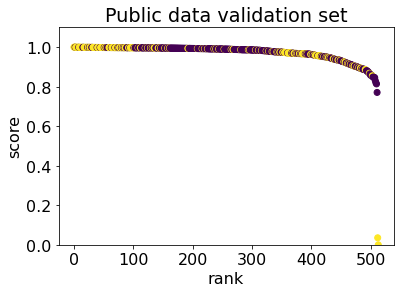

In [ ]:
x=np.arange(len(pub1))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color)
plt.ylim(-0.0,1.1)
#plt.axhline(y=0.84, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')
plt.title('Public data validation set')


Specificity :  0.146875
Roc_auc_score :  0.514159149484536
Recall_score :  0.8814432989690721


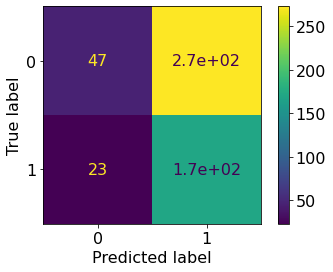

In [ ]:
# Public available
evaluate_public(0.95, pub_validation.score.values, public_label.values)

## Shapley - Feature importance 

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 6.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=051a77f358a076e4e2fe0df5ffc4cb8afb15b0365f6e995dfcd81bcc944f2afb
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
paracetamol

,NAME1,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,...,F10[Cl-X],F10[Br-Br],F10[Br-I],F10[Br-B],F10[Br-Si],F10[Br-X],F10[I-I],F10[I-B],F10[I-Si],F10[I-X],F10[B-B],F10[B-Si],F10[B-X],F10[Si-Si],F10[Si-X],F10[X-X],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
266,CC(=O)Nc1ccc(O)cc1,CN1CCN(C)CC1,0.046577,0.060004,0.060182,0.05865,0.058862,0.063255,0.211754,0.156102,0.112768,0.386724,0.375874,0.064039,0.060345,0.09375,0.064815,0.059259,0.066667,0.061453,0.033333,0.15,0.076923,0.0,0.058252,0.080357,0.069307,0.055556,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.035328,0.020059,0.015129,0.427108,0.000525,0.012200,0.000000,0.047007,0.047007,0.047787,0.0,1.0,1.00,0.6,0.8,0.777778,1.0,1.0,1.0,0.872340,1.000000,1.000000
267,CC(=O)Nc1ccc(O)cc1,C1CN2CCN1CC2,0.046577,0.060004,0.060182,0.05865,0.058862,0.063255,0.211754,0.156102,0.112768,0.386724,0.375874,0.064039,0.060345,0.09375,0.064815,0.059259,0.066667,0.061453,0.033333,0.15,0.076923,0.0,0.058252,0.080357,0.069307,0.055556,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.035328,0.020059,0.015129,0.427108,0.000525,0.012200,0.000000,0.038209,0.038209,0.039100,0.0,1.0,1.00,0.6,0.8,1.000000,0.5,1.0,1.0,0.817629,1.000000,1.000000
268,CC(=O)Nc1ccc(O)cc1,OS(=O)(=O)NC1CCCCC1,0.046577,0.060004,0.060182,0.05865,0.058862,0.063255,0.211754,0.156102,0.112768,0.386724,0.375874,0.064039,0.060345,0.09375,0.064815,0.059259,0.066667,0.061453,0.033333,0.15,0.076923,0.0,0.058252,0.080357,0.069307,0.055556,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235580,0.274777,0.225671,0.205541,0.174589,0.432835,0.001068,0.194873,0.108358,0.066435,0.066435,0.071600,0.0,1.0,1.00,0.8,0.8,1.000000,1.0,1.0,1.0,0.939210,0.666667,1.000000
269,CC(=O)Nc1ccc(O)cc1,CN1CCOCC1,0.046577,0.060004,0.060182,0.05865,0.058862,0.063255,0.211754,0.156102,0.112768,0.386724,0.375874,0.064039,0.060345,0.09375,0.064815,0.059259,0.066667,0.061453,0.033333,0.15,0.076923,0.0,0.058252,0.080357,0.069307,0.055556,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.040424,0.038601,0.029114,0.410959,0.000021,0.027576,0.000000,0.032262,0.032262,0.034074,0.0,1.0,1.00,0.6,0.8,1.000000,1.0,1.0,1.0,0.908815,1.000000,1.000000
270,CC(=O)Nc1ccc(O)cc1,C1COCCN1,0.046577,0.060004,0.060182,0.05865,0.058862,0.063255,0.211754,0.156102,0.112768,0.386724,0.375874,0.064039,0.060345,0.09375,0.064815,0.059259,0.066667,0.061453,0.033333,0.15,0.076923,0.0,0.058252,0.080357,0.069307,0.055556,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142186,0.065810,0.049636,0.393453,0.001189,0.056639,0.035164,0.020846,0.020846,0.021915,0.0,1.0,1.00,0.6,0.8,1.000000,1.0,1.0,1.0,0.908815,1.000000,1.000000
271,CC(=O)Nc1ccc(O)cc1,C1CNCCN1,0.046577,0.060004,0.060182,0.05865,0.058862,0.063255,0.211754,0.156102,0.112768,0.386724,0.375874,0.064039,0.060345,0.09375,0.064815,0.059259,0.066667,0.061453,0.033333,0.15,0.076923,0.0,0.058252,0.080357,0.069307,0.055556,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.266061,0.074478,0.056173,0.393453,0.001189,0.070327,0.070327,0.024176,0.024176,0.023468,0.0,1.0,1.00,0.6,0.8,0.777778,1.0,1.0,1.0,0.872340,1.000000,1.000000
272,CC(=O)Nc1ccc(O)cc1,NC1CCC(N)CC1,0.046577,0.060004,0.060182,0.05865,0.058862,0.063255,0.211754,0.156102,0.112768,0.386724,0.375874,0.064039,0.060345,0.09375,0.

In [ ]:
class  CocryNet(nn.Module):
    def __init__(self, net, R, C):
      
        super().__init__()
        self.net = net
        self.R = torch.Tensor([R]).to("cuda")
        self.C = torch.Tensor([C]).to("cuda")

    def forward(self, x):
        #x = torch.FloatTensor(x).cpu().to(device)
        outputs = self.net(x)
        dist = torch.sum((outputs - self.C) ** 2, dim=1)
        scores = (dist - self.R ** 2)*-1
        #lab = score(deep_SVDD, labelled.iloc[:,1:].values).cpu().detach().numpy()*-1 
        #lab = score(deep_SVDD, rc_data.iloc[:,:].values).cpu().detach().numpy()*-1 
        lab = score(deep_SVDD, nalixidic.iloc[:,2:].values).cpu().detach().numpy()*-1
        M= lab.max()
        m= lab.min()
        scores = (scores - m)/(M-m)
        return scores.unsqueeze(1)
shapNet = CocryNet(deep_SVDD.net, deep_SVDD.R, deep_SVDD.c)

In [ ]:
# Add the '_1' and '_2' at the end of each descriptor to denote the possition of the molecule in the vector
df11=df2.iloc[:,:]
labels1 = df11.rename(columns=lambda x: f"{x}_1")
labels2 = df11.rename(columns=lambda x: f"{x}_2")
dataset1_labels = labels1.columns.values
dataset2_labels = labels2.columns.values

cols = np.concatenate((dataset1_labels, dataset2_labels))
len(cols)


7224

In [ ]:
# Interpretability of the whole bidirectional dataset
import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(nalixidic.iloc[:, 2:].values).to(device)  #df #negatives_data
model = shapNet#.to(device)

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#e = shap.KernelExplainer(model, background)
shap_values = e.shap_values(background, rseed=1, ranked_outputs=10)

In [ ]:
pd.concat([pd.DataFrame(paracetamol.iloc[:,:2].values), pd.DataFrame(y_scaler1.fit_transform(-1*score(deep_SVDD, paracetamol.iloc[:,2:].values).cpu().detach().numpy().reshape(-1,1))),
           pd.DataFrame(paracetamol_label.values),  pd.DataFrame(paracetamol['Eta_D_beta_A'].iloc[:, 1].values)], axis=1, ignore_index=True)

,0,1,2,3,4
0,CC(=O)Nc1ccc(O)cc1,CN1CCN(C)CC1,0.935034,1,0.128788
1,CC(=O)Nc1ccc(O)cc1,C1CN2CCN1CC2,0.979531,1,0.090909
2,CC(=O)Nc1ccc(O)cc1,OS(=O)(=O)NC1CCCCC1,0.604189,1,0.352617
3,CC(=O)Nc1ccc(O)cc1,CN1CCOCC1,0.952892,1,0.134199
4,CC(=O)Nc1ccc(O)cc1,C1COCCN1,0.801807,1,0.141414
5,CC(=O)Nc1ccc(O)cc1,C1CNCCN1,0.732930,1,0.141414
6,CC(=O)Nc1ccc(O)cc1,NC1CCC(N)CC1,0.983349,1,0.204545
7,CC(=O)Nc1ccc(O)cc1,O=C1CC2=CC=CC=C2CO1,0.947028,0,0.586777
8,CC(=O)Nc1ccc(O)cc1,C(CC1=CC=NC=C1)CC1=CC=NC=C1,0.987055,0,0.666667
9,CC(=O)Nc1ccc(O)cc1,C(CC1=CC=NC=C1)C1=CC=NC=C1,0.994136,1,0.696970


In [ ]:
dataset1['Eta_D_beta_A'].describe()

count    5522.000000
mean        0.069432
std         0.245470
min        -0.900000
25%        -0.083333
50%         0.107143
75%         0.250000
max         0.750000
Name: Eta_D_beta_A, dtype: float64

In [ ]:
dataset2['Eta_D_beta_A'].describe()

count    5522.000000
mean        0.126078
std         0.283766
min        -0.900000
25%        -0.022727
50%         0.211538
75%         0.312500
max         0.750000
Name: Eta_D_beta_A, dtype: float64

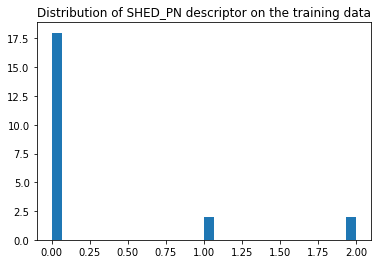

In [ ]:
plt.hist(nalixidic['SHED_PN'].iloc[:, 1], bins=30)#.describe()
#plt.xlim(0,1)
plt.title('Distribution of SHED_PN descriptor on the training data')
plt.savefig('/content/etad_histogram1.png', dpi=600)

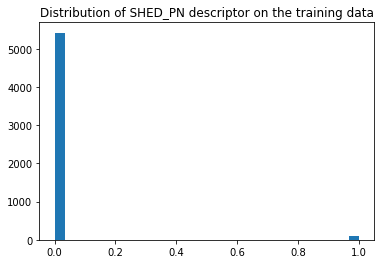

In [ ]:
plt.hist(labelled['SHED_PN'].iloc[:, 1], bins=30)#.describe()
#plt.xlim(0,1)
plt.title('Distribution of SHED_PN descriptor on the training data')
plt.savefig('/content/etad_histogram.png', dpi=600)

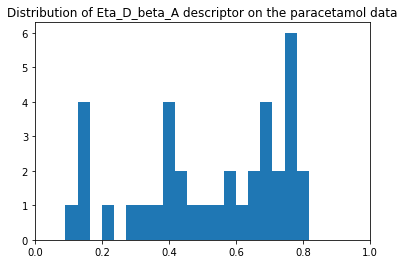

In [ ]:
plt.hist(paracetamol['Eta_D_beta_A'].iloc[:, 1], bins=20)#.describe()
plt.xlim(0,1)
plt.title('Distribution of Eta_D_beta_A descriptor on the paracetamol data')
plt.savefig('etad_histogram1.png', dpi=600)

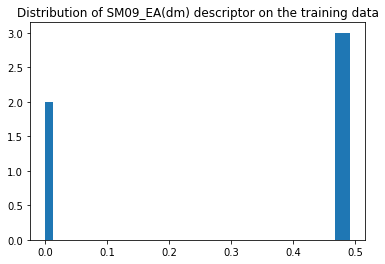

In [ ]:
plt.hist(itraconazole['SM09_EA(dm)'].iloc[:, 1], bins=40)#.describe()
#plt.xlim(0,1)
plt.title('Distribution of SM09_EA(dm) descriptor on the training data')
plt.savefig('/content/etad_histogram.png', dpi=600)

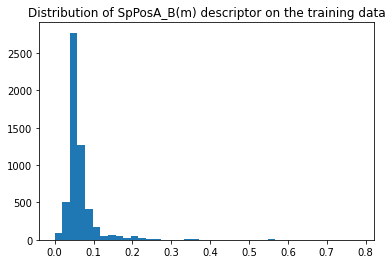

In [ ]:
plt.hist(labelled['SpPosA_B(m)'].iloc[:, 1], bins=40)#.describe()
#plt.xlim(0,1)
plt.title('Distribution of SpPosA_B(m) descriptor on the training data')
plt.savefig('/content/etad1_histogram.png', dpi=600)

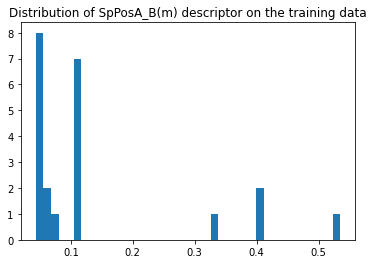

In [ ]:
plt.hist(diclophenac['SpPosA_B(m)'].iloc[:, 1], bins=40)#.describe()
#plt.xlim(0,1)
plt.title('Distribution of SpPosA_B(m) descriptor on the training data')
plt.savefig('/content/etad2_histogram.png', dpi=600)

In [ ]:
pd.concat([pd.DataFrame(diclophenac.iloc[:,:2].values), pd.DataFrame(y_scaler1.fit_transform(-1*score(deep_SVDD, diclophenac.iloc[:,2:].values).cpu().detach().numpy().reshape(-1,1))),
           pd.DataFrame(diclophenac_label.values),  pd.DataFrame(diclophenac['SpPosA_B(m)'].iloc[:, 1].values)], axis=1, ignore_index=True)

,0,1,2,3,4
0,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,COc1ccc(cc1)C1=NN2C=C(C)N=C2S1,0.986712,1,0.080158
1,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,CC1=NN2C=C(C)N=C2S1,0.990942,1,0.105766
2,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,c1cc(ccn1)c1ccncc1,1.000000,1,0.043381
3,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,NC1=CN=CC=C1,0.981394,1,0.043445
4,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,Nc1ccccn1,0.978875,1,0.043885
5,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,CC1=CC(=NC(=N1)N)C,0.978158,1,0.048472
6,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,CC1=CC(=NN1)C,0.886515,0,0.051414
7,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,NC1=C(Br)C=C(Br)C=N1,0.942084,1,0.408728
8,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,Clc1ccccn1,0.889481,0,0.114576
9,OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,NC(=O)c1ccncc1,0.985144,1,0.049512


In [ ]:
pd.concat([pd.DataFrame(itraconazole.iloc[:,:2].values), pd.DataFrame(y_scaler1.fit_transform(-1*score(deep_SVDD, itraconazole.iloc[:,2:].values).cpu().detach().numpy().reshape(-1,1))),
           pd.DataFrame(itraconazole_label.values),  pd.DataFrame(itraconazole['SM09_EA(dm)'].iloc[:, 1].values)], axis=1, ignore_index=True)

,0,1,2,3,4
0,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)C=CC(O)=O,1.000000,1,6.879553e-10
1,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)CC(O)=O,0.118663,0,4.914438e-01
2,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)CCC(O)=O,0.361035,1,4.729323e-01
3,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(CC(O)=O)C(O)=O,0.103539,1,4.810819e-01
4,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(C(O)C(O)=O)C(O)=O,0.277004,1,4.882084e-01
5,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)C=CC(O)=O,1.000000,0,6.879553e-10
6,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)CCCCC(O)=O,0.198445,0,4.729323e-01
7,CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...,OC(=O)CCCC(O)=O,0.000000,0,4.729323e-01


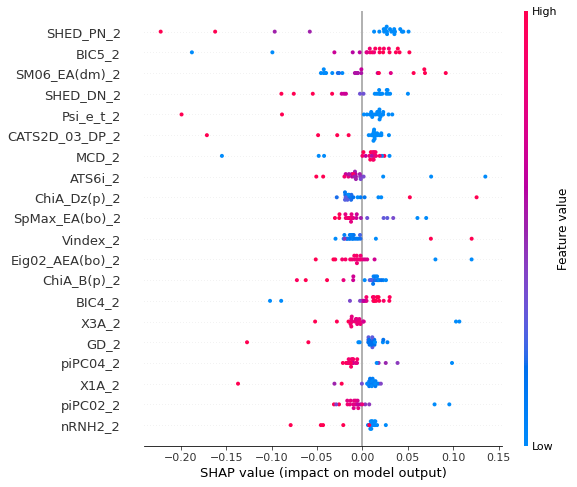

In [ ]:
# Plot the most important features 

X = pd.DataFrame(nalixidic.iloc[:, 2:].values, columns=cols)  #negatives_data

shap.summary_plot(shap_values[:], X ,  color_bar=True, plot_size=(8,8), layered_violin_max_num_bins=100, class_names=None, max_display=20,  show=False)

plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/alva_nalixidic_shap.png', dpi=600, bbox_inches='tight')

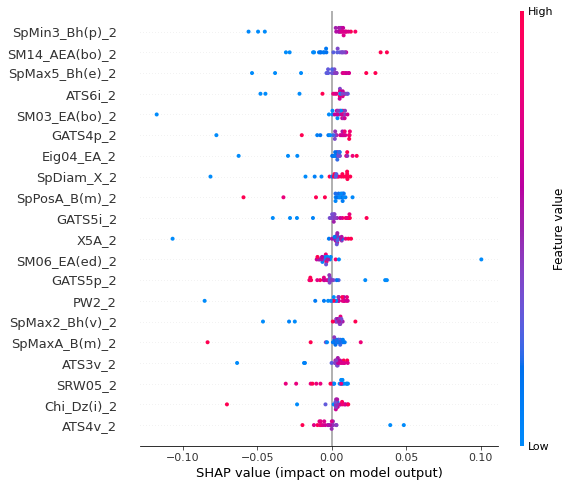

In [ ]:
# Plot the most important features 

X = pd.DataFrame(diclophenac.iloc[:, 2:].values, columns=cols)  #negatives_data

shap.summary_plot(shap_values[:], X ,  color_bar=True, plot_size=(8,8), layered_violin_max_num_bins=100, class_names=None, max_display=20,  show=False)

plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/alva_diclophenac_shap.png', dpi=600, bbox_inches='tight')

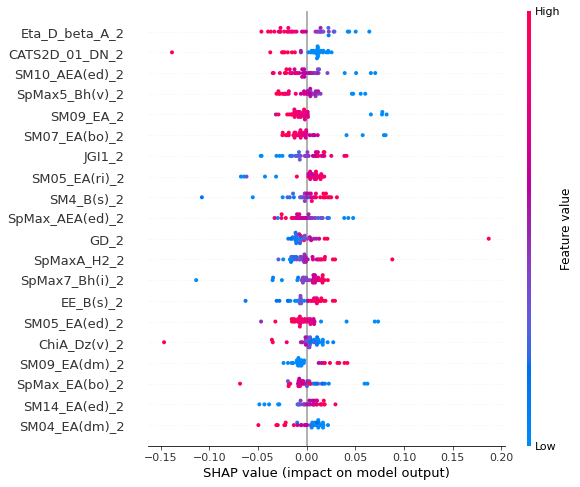

In [ ]:
# Plot the most important features 

X = pd.DataFrame(paracetamol.iloc[:, 2:].values, columns=cols)  #negatives_data

shap.summary_plot(shap_values[:], X ,  color_bar=True, plot_size=(8,8), layered_violin_max_num_bins=100, class_names=None, max_display=20,  show=False)

plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/alva_paracetamol_shap.png', dpi=600, bbox_inches='tight')

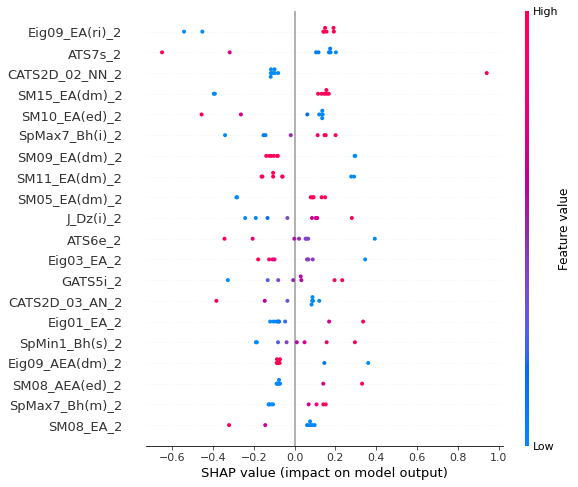

In [ ]:
# Plot the most important features 

X = pd.DataFrame(itraconazole.iloc[:, 2:].values, columns=cols)  #negatives_data

shap.summary_plot(shap_values[:], X ,  color_bar=True, plot_size=(8,8), layered_violin_max_num_bins=100, class_names=None, max_display=20,  show=False)

#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/alva_itraconazole_shap.png', dpi=600, bbox_inches='tight')

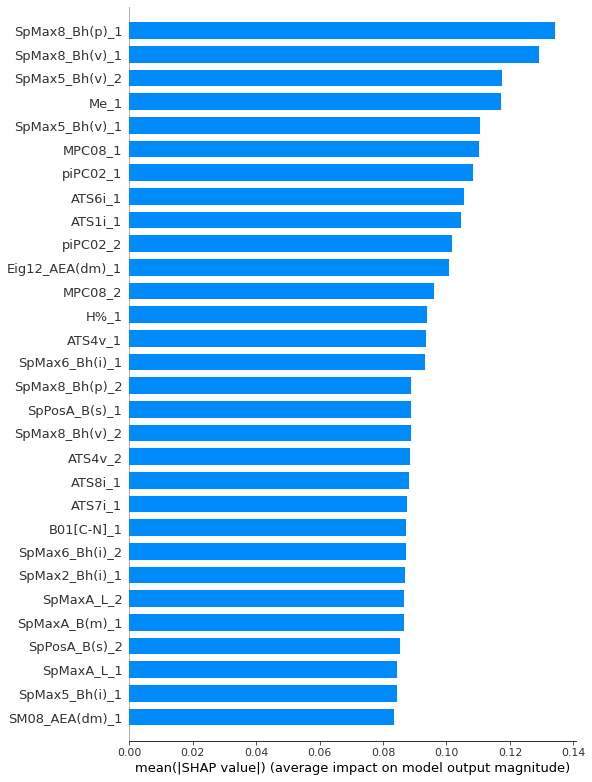

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',max_display=30)

In [ ]:
df =df.drop(columns=['SpMax7_Bh(i)', 'ATS8m', 'B01[C-N]', 'Ro5', 'SpMax2_Bh(m)', 'Eig09_AEA(ri)', 'SpMax_B(m)', 'B03[C-O]', 'ATS8s', 'Eig13_AEA(ed)',
                 'SM4_Dz(v)', 'piPC02', 'B04[C-N]', 'Eig10_EA(ri)', 'cRo5', 'SM13_AEA(bo)', 'SpMin8_Bh(v)', 'SM2_Dz(i)', 'SpPosA_B(s)',
                 'SpMin5_Bh(p)', 'Eig15_AEA(ed)', 'SpMaxA_AEA(ri)', 'B02[C-N]', 'SM05_AEA(ed)', 'SpMin4_Bh(s)', 'SIC1', 'SpMin8_Bh(s)', 'SpMin8_Bh(v)',
                 'SpMin5_Bh(v)', 'Eig12_AEA(ri)', 'piPC06'])

In [ ]:
sh=pd.DataFrame(shap_values, columns=X.columns.values)
sh

,MW_1,AMW_1,Sv_1,Se_1,Sp_1,Si_1,Mv_1,Me_1,Mp_1,Mi_1,GD_1,nAT_1,nSK_1,nTA_1,nBT_1,nBO_1,nBM_1,SCBO_1,RBN_1,RBF_1,nDB_1,nTB_1,nAB_1,nH_1,nC_1,nN_1,nO_1,nP_1,nS_1,nF_1,nCL_1,nBR_1,nI_1,nB_1,nHM_1,nHet_1,nX_1,H%_1,C%_1,N%_1,...,ALOGP_2,ALOGP2_2,SAtot_2,SAacc_2,SAdon_2,Vx_2,VvdwMG_2,VvdwZAZ_2,PDI_2,BLTF96_2,BLTD48_2,BLTA96_2,Ro5_2,cRo5_2,DLS_01_2,DLS_02_2,DLS_03_2,DLS_04_2,DLS_05_2,DLS_06_2,DLS_07_2,DLS_cons_2,LLS_01_2,LLS_02_2,CMC-80_2,CMC-50_2,Inflammat-80_2,Inflammat-50_2,Depressant-80_2,Depressant-50_2,Psychotic-80_2,Psychotic-50_2,Hypertens-80_2,Hypertens-50_2,Hypnotic-80_2,Hypnotic-50_2,Neoplastic-80_2,Neoplastic-50_2,Infective-80_2,Infective-50_2
0,-0.001010,-0.000515,0.008685,0.000624,0.005205,-0.001891,-0.001094,-0.001569,0.011344,0.001166,-0.005937,0.003127,0.000053,0.000432,0.001309,-0.002502,-0.000836,-0.000434,0.000323,-0.009146,-0.001074,0.000682,-0.001704,0.006943,-0.008037,0.003325,-0.001878,0.0,-0.000849,-0.001236,0.000447,0.000187,0.002500,0.0,-0.001805,0.002334,0.015722,-0.001742,0.015989,0.000332,...,0.007080,0.001496,-0.006628,0.002022,0.006296,0.011793,-0.000006,0.001388,0.002794,-0.006404,0.016145,-0.020067,0.018502,0.021435,-0.005322,-0.004821,0.004782,0.003740,-0.000585,0.007209,0.012453,-0.000417,-0.002309,0.006635,-0.004126,-0.001268,0.002063,0.000448,0.000952,0.000373,0.000986,0.000572,0.002097,0.001884,0.000652,0.000472,0.010658,0.001056,-0.002600,0.001598
1,-0.002358,0.001595,0.002025,0.002257,0.005690,-0.000527,-0.002727,0.000245,0.012870,-0.001810,-0.007727,-0.001876,0.000865,-0.000209,-0.000369,-0.000150,0.001678,-0.002701,0.000617,-0.019350,-0.001476,0.000432,-0.002317,0.004203,-0.007709,0.002224,-0.001643,0.0,0.000306,-0.001078,0.000017,0.000059,-0.000804,0.0,-0.000076,0.000176,0.004309,-0.001741,0.022990,-0.000157,...,0.003655,0.008822,-0.010007,-0.000337,-0.008490,0.019826,-0.001556,0.008155,0.003083,0.001247,0.017683,-0.025691,0.023272,0.017507,-0.000556,-0.003994,0.005811,0.002982,-0.003898,0.001176,0.010717,-0.001012,0.010217,0.013566,0.006455,-0.000685,-0.000490,0.000225,0.000463,0.000000,0.000549,0.000074,0.002547,0.000000,-0.001336,-0.000123,0.004060,0.001068,0.004342,0.001720
2,-0.000149,0.004186,0.002015,0.001830,0.004148,-0.000179,-0.004824,-0.002495,0.012086,0.000245,-0.007850,-0.001209,0.000258,0.000218,-0.001504,-0.000278,0.001371,-0.002001,0.000499,-0.012750,-0.002304,0.002748,-0.001098,0.004020,-0.005311,0.000824,-0.001585,0.0,0.000352,-0.001519,-0.000120,-0.000013,0.002303,0.0,0.000258,-0.000102,0.002930,-0.001211,0.017256,-0.003666,...,0.001403,0.000211,-0.005026,-0.001406,-0.007250,0.005436,0.000161,0.002416,0.000420,0.003454,0.009726,-0.013589,0.007764,0.007059,0.001546,-0.002850,0.001333,0.000387,-0.000107,0.001605,0.001834,-0.001058,0.006148,0.004467,0.002330,-0.000519,0.000313,0.000045,0.001069,0.000000,0.000994,0.000000,0.002279,-0.000217,-0.000965,0.000137,0.002861,0.000008,0.006391,0.001907
3,-0.002188,0.000104,0.005328,0.000450,0.006471,-0.002543,0.000269,-0.000428,0.001353,0.001490,-0.001012,-0.000079,-0.001454,-0.001468,-0.000998,-0.001594,-0.000892,0.000358,-0.001810,0.006098,0.002226,0.002367,0.001209,0.003940,0.000584,0.001784,0.000627,0.0,0.000774,0.000226,0.000161,-0.000155,-0.000071,0.0,-0.001572,-0.000958,0.003903,0.000571,-0.003385,0.000413,...,0.003343,0.001679,-0.002905,0.000188,0.009602,0.003881,-0.001834,0.003735,0.003223,0.002565,0.016174,-0.012808,0.013518,0.012274,0.002686,0.005622,0.003544,0.005254,-0.000093,0.000548,0.003166,0.000414,-0.000573,0.009144,0.011646,0.000580,0.001562,0.000417,-0.000734,0.000253,0.000447,0.000000,0.002266,0.000893,0.001735,0.000056,0.003281,0.000913,-0.000867,0.000963
4,0.001184,0.003327,0.001549,-0.000175,0.002309,0.001029,-0.000197,-0.004382,0.000348,-0.000531,-0.004226,0.000298,-0.000112,0.001150,0.000084,-0.002291,-0.000196,0.000616,-0.002108,0.004533,0.006630,-0.000953,-0.000382,0.000593,-0.000446,0.000319,-0.001752,0.0,0.000737,0.000118,-0.000397,-0.000163,0.002995,0.0,0.000077,-0.000872,0.003946,-0.011082,0.001386,0.0

In [ ]:
# retrieve descriptors with a physical meaning based on correlations between descriptors
shap_values[:].shape
pd.concat([X,pd.DataFrame(shap_values) ], axis=1)


,MW_1,AMW_1,Sv_1,Se_1,Sp_1,Si_1,Mv_1,Me_1,Mp_1,Mi_1,GD_1,nAT_1,nSK_1,nTA_1,nBT_1,nBO_1,nBM_1,SCBO_1,RBN_1,RBF_1,nDB_1,nTB_1,nAB_1,nH_1,nC_1,nN_1,nO_1,nP_1,nS_1,nF_1,nCL_1,nBR_1,nI_1,nB_1,nHM_1,nHet_1,nX_1,H%_1,C%_1,N%_1,...,7730,7731,7732,7733,7734,7735,7736,7737,7738,7739,7740,7741,7742,7743,7744,7745,7746,7747,7748,7749,7750,7751,7752,7753,7754,7755,7756,7757,7758,7759,7760,7761,7762,7763,7764,7765,7766,7767,7768,7769
0,0.022494,0.101185,0.019118,0.018923,0.014245,0.020672,0.212555,0.411539,0.045280,0.454955,0.554196,0.019704,0.025862,0.12500,0.018519,0.022222,0.019048,0.022346,0.066667,0.60000,0.153846,0.000,0.000000,0.035714,0.019802,0.000000,0.114286,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.114286,0.00,0.545455,0.200000,0.000000,...,0.007080,0.001496,-0.006628,0.002022,0.006296,0.011793,-0.000006,0.001388,0.002794,-0.006404,0.016145,-0.020067,0.018502,0.021435,-0.005322,-0.004821,0.004782,0.003740,-0.000585,0.007209,0.012453,-0.000417,-0.002309,0.006635,-0.004126,-0.001268,0.002063,0.000448,0.000952,0.000373,0.000986,0.000572,0.002097,0.001884,0.000652,0.000472,0.010658,0.001056,-0.002600,0.001598
1,0.022494,0.101185,0.019118,0.018923,0.014245,0.020672,0.212555,0.411539,0.045280,0.454955,0.554196,0.019704,0.025862,0.12500,0.018519,0.022222,0.019048,0.022346,0.066667,0.60000,0.153846,0.000,0.000000,0.035714,0.019802,0.000000,0.114286,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.114286,0.00,0.545455,0.200000,0.000000,...,0.003655,0.008822,-0.010007,-0.000337,-0.008490,0.019826,-0.001556,0.008155,0.003083,0.001247,0.017683,-0.025691,0.023272,0.017507,-0.000556,-0.003994,0.005811,0.002982,-0.003898,0.001176,0.010717,-0.001012,0.010217,0.013566,0.006455,-0.000685,-0.000490,0.000225,0.000463,0.000000,0.000549,0.000074,0.002547,0.000000,-0.001336,-0.000123,0.004060,0.001068,0.004342,0.001720
2,0.022494,0.101185,0.019118,0.018923,0.014245,0.020672,0.212555,0.411539,0.045280,0.454955,0.554196,0.019704,0.025862,0.12500,0.018519,0.022222,0.019048,0.022346,0.066667,0.60000,0.153846,0.000,0.000000,0.035714,0.019802,0.000000,0.114286,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.114286,0.00,0.545455,0.200000,0.000000,...,0.001403,0.000211,-0.005026,-0.001406,-0.007250,0.005436,0.000161,0.002416,0.000420,0.003454,0.009726,-0.013589,0.007764,0.007059,0.001546,-0.002850,0.001333,0.000387,-0.000107,0.001605,0.001834,-0.001058,0.006148,0.004467,0.002330,-0.000519,0.000313,0.000045,0.001069,0.000000,0.000994,0.000000,0.002279,-0.000217,-0.000965,0.000137,0.002861,0.000008,0.006391,0.001907
3,0.022519,0.084204,0.031170,0.018975,0.030637,0.023868,0.342972,0.133802,0.191074,0.352985,0.554196,0.024631,0.034483,0.03125,0.027778,0.037037,0.066667,0.050279,0.000000,0.00000,0.000000,0.125,0.058252,0.035714,0.049505,0.111111,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.057143,0.00,0.500000,0.450000,0.261905,...,0.003343,0.001679,-0.002905,0.000188,0.009602,0.003881,-0.001834,0.003735,0.003223,0.002565,0.016174,-0.012808,0.013518,0.012274,0.002686,0.005622,0.003544,0.005254,-0.000093,0.000548,0.003166,0.000414,-0.000573,0.009144,0.011646,0.000580,0.001562,0.000417,-0.000734,0.000253,0.000447,0.000000,0.002266,0.000893,0.001735,0.000056,0.003281,0.000913,-0.000867,0.000963
4,0.024078,0.032833,0.042509,0.040975,0.045995,0.048564,0.162887,0.045912,0.114712,0.381056,0.554196,0.049261,0.034483,0.06250,0.050926,0.037037,0.057143,0.039106,0.000000,0.00000,0.000000,0.000,0.058252,0.080357,0.059406,0.055556,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.028571,0.00,0.794118,0.352941,0.092437,...,0.000863,0.000456,0.000264,-0.000386,0.001986,0.005703,0.003920,-0.001240,0.002919,0.010279,0.006225,-0.006336,0.003967,0.003166,-0.001034,-0.006824,-0.003034,0.005599,-0.005333,0.000075,0.000280,-0.001806,-0.004732,0.003042,-0.005926,0.000356,0.000247,0.000359,0.000474,-0.000247,-0.000032,0.000000,0.003503,0.000606,0.006588,0.000238,0.002431,0.002010,0.004991,-0.000182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,

# Using the most important descriptors

## Import the training set

In [ ]:
# Import the datasets 
dataset1=pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/alvadesc_data/dataset1.csv') 
dataset2=pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/alvadesc_data/dataset2.csv')

Columns (51,72,73,74,75,76,77,78,79,80,81,154,157,158,305,306,307,308,309,311,312,313,331,337,338,339,340,341,343,344,345,365,366,367,368,369,370,371,372,373,395,396,397,398,399,401,402,403,426,427,428,429,430,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,517,524,525,526,527,528,530,531,532,551,558,559,560,561,562,564,565,566,585,592,593,594,595,596,598,599,600,619,626,627,628,629,630,632,633,634,653,660,661,662,663,664,666,667,668,687,694,695,696,697,698,700,701,702,727,728,729,730,731,733,734,735,760,761,762,763,764,766,767,768,793,794,795,796,797,799,800,801,826,827,828,829,830,832,833,834,859,860,861,862,863,865,866,867,892,893,894,895,896,898,899,900,3842,3847,3848,3849,3855,3856,3857,3858,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886) have mixed types.Specify dtype op

In [ ]:
df1=dataset1.iloc[:,2:]
print(df1.shape)
df1.dropna(axis=1)
df1.fillna(0)
df1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1)

(5522, 3885)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,C%,N%,...,F10[Cl-X],F10[Br-Br],F10[Br-I],F10[Br-B],F10[Br-Si],F10[Br-X],F10[I-I],F10[I-B],F10[I-Si],F10[I-X],F10[B-B],F10[B-Si],F10[B-X],F10[Si-Si],F10[Si-X],F10[X-X],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
0,104.07,9.460909,6.9128,12.0764,6.3408,12.6680,0.628436,1.097855,0.576436,1.151636,0.285714,11,7,4,10,6,2,8.0,2,0.200000,2,0,0,4,3,0,4,0,0,0,0,0,0,0,0,4,0,36.363636,27.272727,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.584963,1.584963,1.251255,74.60,74.60,-0.805981,0.649605,135.656540,85.366686,112.973422,49.677632,90.34,0,1,1.00,0.833333,0.833333,0.5,0.5,1.000000,1.0,0.809524,0.666667,1.000
1,104.07,9.460909,6.9128,12.0764,6.3408,12.6680,0.628436,1.097855,0.576436,1.151636,0.285714,11,7,4,10,6,2,8.0,2,0.200000,2,0,0,4,3,0,4,0,0,0,0,0,0,0,0,4,0,36.363636,27.272727,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.584963,1.584963,1.251255,74.60,74.60,-0.805981,0.649605,135.656540,85.366686,112.973422,49.677632,90.34,0,1,1.00,0.833333,0.833333,0.5,0.5,1.000000,1.0,0.809524,0.666667,1.000
2,104.07,9.460909,6.9128,12.0764,6.3408,12.6680,0.628436,1.097855,0.576436,1.151636,0.285714,11,7,4,10,6,2,8.0,2,0.200000,2,0,0,4,3,0,4,0,0,0,0,0,0,0,0,4,0,36.363636,27.272727,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.584963,1.584963,1.251255,74.60,74.60,-0.805981,0.649605,135.656540,85.366686,112.973422,49.677632,90.34,0,1,1.00,0.833333,0.833333,0.5,0.5,1.000000,1.0,0.809524,0.666667,1.000
3,104.12,8.676667,8.5696,12.0872,8.7728,13.4118,0.714133,1.007267,0.731067,1.117650,0.285714,12,8,1,12,8,7,13.0,0,0.000000,0,1,6,4,6,2,0,0,0,0,0,0,0,0,0,2,0,33.333333,50.000000,16.666667,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,2.584963,-0.709796,36.68,36.68,0.142767,0.020382,47.844885,0.000000,137.873754,59.882686,97.90,0,1,1.00,0.666667,0.833333,0.4,0.0,1.000000,1.0,0.700000,1.000000,1.000
4,107.17,6.304118,10.1286,16.6362,11.0513,19.1591,0.595800,0.978600,0.650076,1.127006,0.285714,17,8,2,17,8,6,11.0,0,0.000000,0,0,6,9,7,1,0,0,0,0,0,0,0,0,0,1,0,52.941176,41.176471,5.882353,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.807355,2.000000,-0.828095,12.89,12.89,1.199143,1.437943,16.785530,0.000000,158.986711,68.535537,109.48,0,1,1.00,0.666667,0.833333,0.7,0.5,1.000000,1.0,0.814286,1.000000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,1429.75,6.808333,117.5188,214.9371,121.5459,240.5802,0.559613,1.023510,0.578790,1.145620,0.022091,210,98,21,217,105,0,105.0,28,0.129032,0,0,0,112,63,0,35,0,0,0,0,0,0,0,0,35,0,53.333333,30.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,-0.641437,323.05,323.05,-8.593375,73.846089,384.996076,0.000000,1689.534884,695.809379,1307.23,1,0,0.50,0.166667,0.333333,0.5,1.0,0.333333,0.0,0.404762,0.333333,0.375
5518,1556.32,12.969333,82.2256,117.4680,96.4104,131.5352,0.685213,0.978900,0.803420,1.096127,0.035714,120,64,8,128,72,48,96.0,8,0.062500,0,0,48,56,56,0,0,0,0,0,0,4,4,0,8,8,8,46.666667,46.666667,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.614710,4.643856,-0.871750,0.00,0.00,13.713610,188.063094,0.000000,0.000000,1340.000000,552.557377,914.92,1,0,0.50,0.333333,0.666667,0.3,0.0,0.666667,1.0,0.495238,0.500000,0.375
5519,1735.14,9.328710,132.6036,185.9556,142.0236,204.5106,0.712923,0.999761,0.763568,1.099519,0.020494,186,114,24,204,132,90,177.0,18,0.088235,0,0,90,72,96,6,0,0,0,0,12,0,0,0,12,18,12,38.709677,51.612903,3.225806,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.507795,5.523562,2.033303,72.18,72.18,12.860006,165.379755,108.064504,108.064504,1987.076412,817.752628,1372.98,1,0,0.25,0.1

In [ ]:
df1=dataset1.iloc[:,2:]
#df1 = df1.fillna(0)
df2=dataset2.iloc[:,2:]
#df2 = df2.fillna(0)
#df1=df1.dropna(axis=1)
#df2=df2[df1.columns.values]
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1) #.fillna(0)
df2 = df2.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1) #.fillna(0)
columns_to_keep = [x for x in df1.columns.values if x in df2.columns.values]
print(df1.shape)
print(df2.shape)
print(len(columns_to_keep))

df2=df2[df1.columns.values]

(5522, 3612)
(5522, 3633)
3612


In [ ]:
#df1 = df1[df1.columns[df1.columns.isin(interpretable)]]
df2=df2[df1.columns.values]

In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Entry'], dataset11, dataset22], axis=1), pd.concat([dataset1['Entry'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
top_30=['SpMax7_Bh(i)', 'ATS8m', 'B01[C-N]', 'Ro5', 'SpMax2_Bh(m)', 'Eig09_AEA(ri)', 'SpMax_B(m)', 'B03[C-O]', 'ATS8s', 'Eig13_AEA(ed)',
                 'SM4_Dz(v)', 'piPC02', 'B04[C-N]', 'Eig10_EA(ri)', 'cRo5', 'SM13_AEA(bo)', 'SpMin8_Bh(v)', 'SM2_Dz(i)', 'SpPosA_B(s)',
                 'SpMin5_Bh(p)', 'Eig15_AEA(ed)', 'SpMaxA_AEA(ri)', 'B02[C-N]', 'SM05_AEA(ed)', 'SpMin4_Bh(s)', 'SIC1', 'SpMin8_Bh(s)', 'SpMin8_Bh(v)',
                 'SpMin5_Bh(v)', 'Eig12_AEA(ri)', 'piPC06']
          
interpretable = ['Se', 'nBT', 'nAT', 'Si', 'Sv', 'nBT', 'Sp', 'Vx', 'SAtot', 'nC', 'nSK', 'UNIP', 'CSI', 'GD', 'nBO', 'MW', 'Xt','TPC','ECC', 'VvdwZAZ', 'VAR',
                  'BBI', 'nBO', 'Pol', 'CENT', 'Qindex', 'AMR', 'Ram', 'SCBO', 'Me', 'MAXDN']

In [ ]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()


df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_concat = df_concat.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)
df1_scaled = df1_scaled[df1_scaled.columns[df1_scaled.columns.isin(interpretable)]]
df2_scaled = df2_scaled[df2_scaled.columns[df2_scaled.columns.isin(interpretable)]]

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)
df

,Entry,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ
0,URMALN,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.000000,0.000000,0.001213,0.000000,0.007580,0.270377,1.000000,0.004926,0.000000,0.004630,0.000000,0.000000,0.000000,0.005618,0.000000,1.000000,0.014286,0.000000,0.000000,0.000000,0.000128,0.002222,0.000000,0.285510,0.000000,0.000000,0.000000
1,GUDTAC,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.010240,0.016622,0.009303,0.017157,0.015274,0.138258,0.791958,0.014778,0.017241,0.018519,0.022222,0.027933,0.029703,0.016854,0.013333,0.452999,0.000000,0.010526,0.004643,0.006390,0.000000,0.000000,0.005093,0.041240,0.097792,0.013725,0.010241
2,GUDTEG,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.010240,0.016622,0.009303,0.017157,0.015274,0.138258,0.791958,0.014778,0.017241,0.018519,0.022222,0.027933,0.029703,0.016854,0.013333,0.452999,0.000000,0.010526,0.004643,0.006390,0.000000,0.000000,0.005093,0.041240,0.097792,0.013725,0.010241
3,PAVGOK,0.022519,0.031170,0.018975,0.030637,0.023868,0.133802,0.554196,0.024631,0.034483,0.027778,0.037037,0.050279,0.049505,0.022472,0.026667,0.389026,0.014286,0.024561,0.010131,0.009585,0.000681,0.011111,0.009621,0.115790,0.139408,0.029588,0.030848,0.015321,0.008013,0.004977,0.002373,0.005997,0.568654,0.653263,0.004926,0.017241,0.004630,0.014815,0.016760,0.009901,0.011236,0.013333,0.670367,0.028571,0.014035,0.003799,0.004260,0.000341,0.004444,0.002830,0.398657,0.055880,0.006028,0.013375
4,JOLCIY,0.024078,0.042509,0.040975,0.045995,0.048564,0.045912,0.554196,0.049261,0.034483,0.050926,0.037037,0.039106,0.059406,0.028090,0.031111,0.403706,0.028571,0.024561,0.008864,0.010650,0.000383,0.006667,0.008489,0.066090,0.140698,0.039886,0.038987,0.000000,0.000000,0.001213,0.000000,0.007580,0.270377,1.000000,0.004926,0.000000,0.004630,0.000000,0.000000,0.000000,0.005618,0.000000,1.000000,0.014286,0.000000,0.000000,0.000000,0.000128,0.002222,0.000000,0.285510,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,COYXET20_,0.094172,0.117952,0.112146,0.114239,0.115192,0.146386,0.218143,0.118227,0.120690,0.120370,0.118519,0.122905,0.138614,0.067416,0.102222,0.213166,0.085714,0.094737,0.055298,0.052183,0.006728,0.046667,0.051688,0.299589,0.293255,0.111328,0.121383,0.700206,0.823643,1.000000,0.790745,1.000000,0.183603,0.005749,1.000000,0.810345,0.976852,0.755556,0.564246,0.613861,0.331461,0.640000,0.018075,0.500000,0.687719,0.803715,1.000000,0.174374,0.316667,0.761554,0.291493,0.839230,0.786386,0.880831
5518,FASMUH_,0.367101,0.267882,0.244569,0.296418,0.248839,0.046832,0.110788,0.261084,0.241379,0.268519,0.244444,0.245810,0.267327,0.162921,0.226667,0.115162,0.171429,0.196491,0.124525,0.116081,0.037813,0.133333,0.122807,0.321738,0.429416,0.289124,0.282231,0.764911,0.566928,0.528619,0.621328,0.531439,0.046832,0.034091,0.556650,0.517241,0.564815,0.511111,0.513966,0.544554,0.308989,0.466667,0.044692,0.342857,0.449123,0.306036,0.303514,0.184636,0.311111,0.301641,0.444057,0.555388,0.615906,0.605094
5519,DOKQEC_,0.132089,0.137164,0.090516,0.141543,0.086577,0.097897,0.22727

In [ ]:
labelled = pd.concat([df1_scaled, df2_scaled], axis=1)
labelled

,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ
0,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.000000,0.000000,0.001213,0.000000,0.007580,0.270377,1.000000,0.004926,0.000000,0.004630,0.000000,0.000000,0.000000,0.005618,0.000000,1.000000,0.014286,0.000000,0.000000,0.000000,0.000128,0.002222,0.000000,0.285510,0.000000,0.000000,0.000000
1,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.010240,0.016622,0.009303,0.017157,0.015274,0.138258,0.791958,0.014778,0.017241,0.018519,0.022222,0.027933,0.029703,0.016854,0.013333,0.452999,0.000000,0.010526,0.004643,0.006390,0.000000,0.000000,0.005093,0.041240,0.097792,0.013725,0.010241
2,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.010240,0.016622,0.009303,0.017157,0.015274,0.138258,0.791958,0.014778,0.017241,0.018519,0.022222,0.027933,0.029703,0.016854,0.013333,0.452999,0.000000,0.010526,0.004643,0.006390,0.000000,0.000000,0.005093,0.041240,0.097792,0.013725,0.010241
3,0.022519,0.031170,0.018975,0.030637,0.023868,0.133802,0.554196,0.024631,0.034483,0.027778,0.037037,0.050279,0.049505,0.022472,0.026667,0.389026,0.014286,0.024561,0.010131,0.009585,0.000681,0.011111,0.009621,0.115790,0.139408,0.029588,0.030848,0.015321,0.008013,0.004977,0.002373,0.005997,0.568654,0.653263,0.004926,0.017241,0.004630,0.014815,0.016760,0.009901,0.011236,0.013333,0.670367,0.028571,0.014035,0.003799,0.004260,0.000341,0.004444,0.002830,0.398657,0.055880,0.006028,0.013375
4,0.024078,0.042509,0.040975,0.045995,0.048564,0.045912,0.554196,0.049261,0.034483,0.050926,0.037037,0.039106,0.059406,0.028090,0.031111,0.403706,0.028571,0.024561,0.008864,0.010650,0.000383,0.006667,0.008489,0.066090,0.140698,0.039886,0.038987,0.000000,0.000000,0.001213,0.000000,0.007580,0.270377,1.000000,0.004926,0.000000,0.004630,0.000000,0.000000,0.000000,0.005618,0.000000,1.000000,0.014286,0.000000,0.000000,0.000000,0.000128,0.002222,0.000000,0.285510,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,0.700206,0.823643,1.000000,0.790745,1.000000,0.183603,0.005749,1.000000,0.810345,0.976852,0.755556,0.564246,0.613861,0.331461,0.640000,0.018075,0.500000,0.687719,0.803715,1.000000,0.174374,0.316667,0.761554,0.291493,0.839230,0.786386,0.880831,0.094172,0.117952,0.112146,0.114239,0.115192,0.146386,0.218143,0.118227,0.120690,0.120370,0.118519,0.122905,0.138614,0.067416,0.102222,0.213166,0.085714,0.094737,0.055298,0.052183,0.006728,0.046667,0.051688,0.299589,0.293255,0.111328,0.121383
5518,0.764911,0.566928,0.528619,0.621328,0.531439,0.046832,0.034091,0.556650,0.517241,0.564815,0.511111,0.513966,0.544554,0.308989,0.466667,0.044692,0.342857,0.449123,0.306036,0.303514,0.184636,0.311111,0.301641,0.444057,0.555388,0.615906,0.605094,0.367101,0.267882,0.244569,0.296418,0.248839,0.046832,0.110788,0.261084,0.241379,0.268519,0.244444,0.245810,0.267327,0.162921,0.226667,0.115162,0.171429,0.196491,0.124525,0.116081,0.037813,0.133333,0.122807,0.321738,0.429416,0.289124,0.282231
5519,0.856327,0.933366,0.859839,0.928767,0.845011,0.110791,0.002426,0.881773,0.948276,0.916667,0.955556,0.966480,0.940594,0.657303,0.9200

## Import validation sets

In [ ]:
# First validation set from Richard Cooper paper : 'Will they co-crystalize?', where they performed experimental screening in 680 molecular pairs

rc_1=  pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/RC_validation_set/RCAPICCDCsmi.csv')
rc_2= pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/RC_validation_set/RCcoformerCCDCsmi.csv')
RC_data = pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/RC_validation_set/RCcocrystals_training.csv',  encoding='latin1')
rc_label = RC_data['Co-crystal']
rc1= rc_1.iloc[:,1:]
rc2= rc_2.iloc[:,2:]
#rc1 = rc1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
#rc2 = rc2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
rc1=rc1[df1.columns.values]
rc2=rc2[df1.columns.values]
rc_1_scaled = pd.DataFrame(X_scaler.transform(rc1), columns=df1.columns.values[:])
rc_2_scaled = pd.DataFrame(X_scaler.transform(rc2), columns=df1.columns.values[:])

rc_1_scaled = rc_1_scaled[rc_1_scaled.columns[rc_1_scaled.columns.isin(interpretable)]]
rc_2_scaled = rc_2_scaled[rc_2_scaled.columns[rc_2_scaled.columns.isin(interpretable)]]

rc_data=pd.concat([rc_1_scaled, rc_2_scaled], axis =1)
rc_data.head()

Columns (309,336,337,338,339,340,342,343,344,399,430,457,458,459,460,461,463,464,465,731,764,797,830,863,896) have mixed types.Specify dtype option on import or set low_memory=False.


,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ
0,0.031731,0.040201,0.034504,0.038833,0.039443,0.172454,0.479895,0.039409,0.043103,0.041667,0.044444,0.050279,0.049505,0.02809,0.035556,0.370266,0.028571,0.031579,0.012241,0.011715,0.001065,0.011111,0.011319,0.24077,0.155822,0.037828,0.038882,0.054731,0.055643,0.048433,0.047984,0.048595,0.324010,0.338048,0.049261,0.068966,0.050926,0.066667,0.078212,0.059406,0.039326,0.057778,0.315192,0.057143,0.056140,0.018995,0.020234,0.002385,0.017778,0.016789,0.337611,0.200937,0.051941,0.059989
1,0.031731,0.040201,0.034504,0.038833,0.039443,0.172454,0.479895,0.039409,0.043103,0.041667,0.044444,0.050279,0.049505,0.02809,0.035556,0.370266,0.028571,0.031579,0.012241,0.011715,0.001065,0.011111,0.011319,0.24077,0.155822,0.037828,0.038882,0.054731,0.055643,0.048433,0.047984,0.048595,0.324010,0.338048,0.049261,0.068966,0.050926,0.066667,0.078212,0.059406,0.039326,0.057778,0.315192,0.057143,0.052632,0.021950,0.023429,0.002001,0.017778,0.019430,0.323716,0.200937,0.051941,0.059989
2,0.031731,0.040201,0.034504,0.038833,0.039443,0.172454,0.479895,0.039409,0.043103,0.041667,0.044444,0.050279,0.049505,0.02809,0.035556,0.370266,0.028571,0.031579,0.012241,0.011715,0.001065,0.011111,0.011319,0.24077,0.155822,0.037828,0.038882,0.054731,0.055643,0.048433,0.047984,0.048595,0.324010,0.338048,0.049261,0.068966,0.050926,0.066667,0.078212,0.059406,0.039326,0.057778,0.315192,0.057143,0.052632,0.024905,0.026624,0.001618,0.017778,0.022071,0.315130,0.200937,0.051941,0.059989
3,0.031731,0.040201,0.034504,0.038833,0.039443,0.172454,0.479895,0.039409,0.043103,0.041667,0.044444,0.050279,0.049505,0.02809,0.035556,0.370266,0.028571,0.031579,0.012241,0.011715,0.001065,0.011111,0.011319,0.24077,0.155822,0.037828,0.038882,0.039906,0.046846,0.040958,0.043274,0.043041,0.232762,0.422106,0.044335,0.051724,0.046296,0.051852,0.055866,0.059406,0.033708,0.044444,0.353419,0.042857,0.042105,0.013930,0.013845,0.001448,0.013333,0.012639,0.317435,0.172958,0.042584,0.047935
4,0.031731,0.040201,0.034504,0.038833,0.039443,0.172454,0.479895,0.039409,0.043103,0.041667,0.044444,0.050279,0.049505,0.02809,0.035556,0.370266,0.028571,0.031579,0.012241,0.011715,0.001065,0.011111,0.011319,0.24077,0.155822,0.037828,0.038882,0.039906,0.046846,0.040958,0.043274,0.043041,0.232762,0.422106,0.044335,0.051724,0.046296,0.051852,0.055866,0.059406,0.033708,0.044444,0.353419,0.042857,0.038596,0.014774,0.014909,0.001363,0.013333,0.013394,0.308150,0.172958,0.042584,0.047935


In [ ]:
# Second validation set: Publically available data from 

public_1=  pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/PublicallyAvailable_validation_set/APICCDCsmi.csv')
public_2= pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/PublicallyAvailable_validation_set/coformerCCDCsmi.csv')
public_data = pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/PublicallyAvailable_validation_set/PublicallyAvalibledata.csv', encoding='latin1')
public_label = public_data['Co-crystal']
#Scale the negatives based on the potitives
pub1= public_1.iloc[:,1:]
pub2= public_2.iloc[:,1:]
#pub1 = pub1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
#pub2 = pub2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

pub1=pub1[df1.columns.values]
pub2=pub2[df1.columns.values]

public_1_scaled = pd.DataFrame(X_scaler.transform(pub1), columns=df1.columns.values[:])
public_2_scaled = pd.DataFrame(X_scaler.transform(pub2), columns=df1.columns.values[:])

public_1_scaled = public_1_scaled[public_1_scaled.columns[public_1_scaled.columns.isin(interpretable)]]
public_2_scaled = public_2_scaled[public_2_scaled.columns[public_2_scaled.columns.isin(interpretable)]]

public=pd.concat([public_1_scaled, public_2_scaled], axis =1)
public.head()

Columns (156) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (304,305,306,307,308,309,310,311,312,394,395,396,397,398,399,400,401,402,425,426,427,428,429,430,431,432,433,523,524,525,526,527,529,530,531,557,558,559,560,561,563,564,565,591,592,593,594,595,597,598,599,625,626,627,628,629,631,632,633,659,660,661,662,663,665,666,667,693,694,695,696,697,699,700,701,731,764,797,830,863,896) have mixed types.Specify dtype option on import or set low_memory=False.


,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ
0,0.120694,0.123526,0.109017,0.121131,0.109311,0.183614,0.203114,0.1133,0.12931,0.115741,0.125926,0.128492,0.128713,0.067416,0.106667,0.203892,0.085714,0.094737,0.055298,0.052183,0.009027,0.051111,0.051311,0.291907,0.303221,0.126406,0.134069,0.094708,0.107571,0.097111,0.107422,0.100669,0.138186,0.250437,0.103448,0.112069,0.111111,0.118519,0.125698,0.108911,0.084270,0.106667,0.203892,0.085714,0.080702,0.056564,0.046858,0.006196,0.055556,0.056216,0.092957,0.325556,0.103088,0.096172
1,0.120694,0.123526,0.109017,0.121131,0.109311,0.183614,0.203114,0.1133,0.12931,0.115741,0.125926,0.128492,0.128713,0.067416,0.106667,0.203892,0.085714,0.094737,0.055298,0.052183,0.009027,0.051111,0.051311,0.291907,0.303221,0.126406,0.134069,0.047625,0.051066,0.043455,0.053654,0.048935,0.138395,0.468337,0.049261,0.051724,0.055556,0.059259,0.064246,0.049505,0.056180,0.057778,0.315192,0.057143,0.035088,0.015618,0.014909,0.001022,0.014444,0.015657,0.078251,0.214823,0.049089,0.038952
2,0.120694,0.123526,0.109017,0.121131,0.109311,0.183614,0.203114,0.1133,0.12931,0.115741,0.125926,0.128492,0.128713,0.067416,0.106667,0.203892,0.085714,0.094737,0.055298,0.052183,0.009027,0.051111,0.051311,0.291907,0.303221,0.126406,0.134069,0.049143,0.067928,0.056539,0.067862,0.061812,0.089203,0.369570,0.064039,0.068966,0.069444,0.074074,0.083799,0.089109,0.044944,0.057778,0.264989,0.028571,0.049123,0.024905,0.022364,0.002299,0.020000,0.024712,0.056320,0.231371,0.062968,0.061282
3,0.120694,0.123526,0.109017,0.121131,0.109311,0.183614,0.203114,0.1133,0.12931,0.115741,0.125926,0.128492,0.128713,0.067416,0.106667,0.203892,0.085714,0.094737,0.055298,0.052183,0.009027,0.051111,0.051311,0.291907,0.303221,0.126406,0.134069,0.017412,0.027728,0.023249,0.029029,0.029949,0.104637,0.653263,0.029557,0.025862,0.032407,0.029630,0.033520,0.039604,0.022472,0.022222,0.426709,0.014286,0.017544,0.006754,0.007455,0.000298,0.005556,0.006791,0.109181,0.120437,0.025140,0.022400
4,0.120694,0.123526,0.109017,0.121131,0.109311,0.183614,0.203114,0.1133,0.12931,0.115741,0.125926,0.128492,0.128713,0.067416,0.106667,0.203892,0.085714,0.094737,0.055298,0.052183,0.009027,0.051111,0.051311,0.291907,0.303221,0.126406,0.134069,0.017412,0.027728,0.023249,0.029029,0.029949,0.104637,0.653263,0.029557,0.025862,0.032407,0.029630,0.033520,0.039604,0.022472,0.022222,0.426709,0.014286,0.017544,0.006754,0.007455,0.000298,0.005556,0.006791,0.125043,0.120437,0.025140,0.022400


In [ ]:
# Third validation set: Artemisin

artemicin_1=  pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/Artemisinin/artemisininAPIalvadesc.csv')
artemicin_2= pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/Artemisinin/artemisininCoformersalvadesc.csv')
artemicin_data = pd.read_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/Artemisinin/artemisinin.csv')
artemicin_label = artemicin_data['Cocrystal']
#Scale the negatives based on the potitives
art1= artemicin_1.iloc[:,1:]
art2= artemicin_2.iloc[:,1:]

art1=art1[df1.columns.values]
art2=art2[df1.columns.values]

#art1 = art1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
#art2 = art2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
artem_1_scaled = pd.DataFrame(X_scaler.transform(art1), columns=df1.columns.values[:])
artem_2_scaled = pd.DataFrame(X_scaler.transform(art2), columns=df1.columns.values[:])

artem_1_scaled = artem_1_scaled[artem_1_scaled.columns[artem_1_scaled.columns.isin(interpretable)]]
artem_2_scaled = artem_2_scaled[artem_2_scaled.columns[artem_2_scaled.columns.isin(interpretable)]]

artemicin=pd.concat([artem_1_scaled, artem_2_scaled], axis =1)
artemicin.head()

,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ
0,0.113644,0.14609,0.165362,0.144378,0.170834,0.137518,0.21163,0.172414,0.137931,0.180556,0.148148,0.111732,0.138614,0.134831,0.155556,0.180064,0.142857,0.168421,0.045589,0.043663,0.007963,0.043333,0.046218,0.23335,0.413302,0.127475,0.144732,0.051178,0.067300,0.058157,0.065563,0.061113,0.140496,0.369570,0.064039,0.068966,0.069444,0.074074,0.081006,0.089109,0.056180,0.066667,0.277907,0.057143,0.059649,0.020684,0.021299,0.001746,0.017778,0.020374,0.180168,0.245443,0.059792,0.060031
1,0.113644,0.14609,0.165362,0.144378,0.170834,0.137518,0.21163,0.172414,0.137931,0.180556,0.148148,0.111732,0.138614,0.134831,0.155556,0.180064,0.142857,0.168421,0.045589,0.043663,0.007963,0.043333,0.046218,0.23335,0.413302,0.127475,0.144732,0.024585,0.038833,0.037194,0.040901,0.044624,0.083623,0.554196,0.044335,0.034483,0.046296,0.037037,0.039106,0.049505,0.028090,0.031111,0.403706,0.028571,0.024561,0.008864,0.010650,0.000383,0.006667,0.008489,0.108917,0.140698,0.036556,0.034559
2,0.113644,0.14609,0.165362,0.144378,0.170834,0.137518,0.21163,0.172414,0.137931,0.180556,0.148148,0.111732,0.138614,0.134831,0.155556,0.180064,0.142857,0.168421,0.045589,0.043663,0.007963,0.043333,0.046218,0.23335,0.413302,0.127475,0.144732,0.047083,0.056506,0.054869,0.053768,0.059315,0.193658,0.375874,0.059113,0.060345,0.060185,0.059259,0.061453,0.059406,0.039326,0.053333,0.338181,0.057143,0.045614,0.017307,0.018104,0.001703,0.015556,0.015469,0.307294,0.188509,0.053999,0.057219
3,0.113644,0.14609,0.165362,0.144378,0.170834,0.137518,0.21163,0.172414,0.137931,0.180556,0.148148,0.111732,0.138614,0.134831,0.155556,0.180064,0.142857,0.168421,0.045589,0.043663,0.007963,0.043333,0.046218,0.23335,0.413302,0.127475,0.144732,0.025086,0.036603,0.033449,0.037186,0.039086,0.127855,0.554196,0.039409,0.034483,0.041667,0.037037,0.039106,0.049505,0.028090,0.031111,0.403706,0.028571,0.024561,0.008864,0.010650,0.000383,0.006667,0.008489,0.166019,0.140698,0.033226,0.033006
4,0.113644,0.14609,0.165362,0.144378,0.170834,0.137518,0.21163,0.172414,0.137931,0.180556,0.148148,0.111732,0.138614,0.134831,0.155556,0.180064,0.142857,0.168421,0.045589,0.043663,0.007963,0.043333,0.046218,0.23335,0.413302,0.127475,0.144732,0.047584,0.054276,0.051123,0.050053,0.053776,0.236630,0.375874,0.054187,0.060345,0.055556,0.059259,0.061453,0.059406,0.039326,0.053333,0.338181,0.057143,0.049123,0.016885,0.017039,0.001852,0.016667,0.015091,0.325714,0.188509,0.050669,0.055666


In [ ]:
# Validation set of paracetamol

par_1 = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/alvadesc_data/paracetamol.csv') 
par_2 = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/alvadesc_data/paracetamol_validation.csv') 

par1= par_1.iloc[:,2:]
par2= par_2.iloc[:,3:]
#par1 = par1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
#par2 = par2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)


par1=par1[df1.columns.values]
par2=par2[df1.columns.values]
#Scale the negatives based on the potitives
paracetamol_1_scaled = pd.DataFrame(X_scaler.transform(par1), columns=df1.columns.values[:])
paracetamol_2_scaled = pd.DataFrame(X_scaler.transform(par2), columns=df1.columns.values[:])


#paracetamol_1_scaled  = paracetamol_1_scaled[paracetamol_1_scaled.columns[paracetamol_1_scaled.columns.isin(top_30)]]
#paracetamol_2_scaled = paracetamol_2_scaled[paracetamol_2_scaled.columns[paracetamol_2_scaled.columns.isin(top_30)]]

#def neg_concat_bidirectional(dataset11, dataset22):
 # return pd.concat([pd.concat([par2['id'], dataset11, dataset22], axis=1), pd.concat([par2['id'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])
par_label= par_2.label
paracetamol=pd.concat([paracetamol_1_scaled, paracetamol_2_scaled], axis =1)
paracetamol.head()#_validation

,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ
0,0.046577,0.060182,0.05865,0.058862,0.063255,0.156102,0.375874,0.064039,0.060345,0.064815,0.059259,0.061453,0.069307,0.033708,0.048889,0.328212,0.042857,0.038596,0.022372,0.020234,0.001916,0.02,0.019996,0.203485,0.18636,0.057329,0.061647,0.068580,0.078638,0.080034,0.074065,0.085082,0.202556,0.302717,0.083744,0.086207,0.087963,0.088889,0.086592,0.069307,0.073034,0.088889,0.266109,0.100000,0.087719,0.025327,0.026624,0.002640,0.021111,0.024146,0.231454,0.269158,0.072787,0.076154
1,0.046577,0.060182,0.05865,0.058862,0.063255,0.156102,0.375874,0.064039,0.060345,0.064815,0.059259,0.061453,0.069307,0.033708,0.048889,0.328212,0.042857,0.038596,0.022372,0.020234,0.001916,0.02,0.019996,0.203485,0.18636,0.057329,0.061647,0.010240,0.016622,0.009303,0.017157,0.015274,0.138258,0.791958,0.014778,0.017241,0.018519,0.022222,0.027933,0.029703,0.016854,0.013333,0.452999,0.000000,0.010526,0.004643,0.006390,0.000000,0.000000,0.005093,0.041240,0.097792,0.013725,0.010241
2,0.046577,0.060182,0.05865,0.058862,0.063255,0.156102,0.375874,0.064039,0.060345,0.064815,0.059259,0.061453,0.069307,0.033708,0.048889,0.328212,0.042857,0.038596,0.022372,0.020234,0.001916,0.02,0.019996,0.203485,0.18636,0.057329,0.061647,0.063488,0.090140,0.084431,0.091606,0.091162,0.066902,0.302717,0.093596,0.086207,0.097222,0.088889,0.094972,0.108911,0.044944,0.066667,0.238343,0.028571,0.052632,0.039257,0.036209,0.003577,0.028889,0.038295,0.050017,0.248860,0.085799,0.085601
3,0.046577,0.060182,0.05865,0.058862,0.063255,0.156102,0.375874,0.064039,0.060345,0.064815,0.059259,0.061453,0.069307,0.033708,0.048889,0.328212,0.042857,0.038596,0.022372,0.020234,0.001916,0.02,0.019996,0.203485,0.18636,0.057329,0.061647,0.049143,0.067928,0.056539,0.067862,0.061812,0.089203,0.369570,0.064039,0.068966,0.069444,0.074074,0.083799,0.089109,0.044944,0.057778,0.264989,0.028571,0.049123,0.024905,0.022364,0.002299,0.020000,0.024712,0.056320,0.231371,0.062968,0.061282
4,0.046577,0.060182,0.05865,0.058862,0.063255,0.156102,0.375874,0.064039,0.060345,0.064815,0.059259,0.061453,0.069307,0.033708,0.048889,0.328212,0.042857,0.038596,0.022372,0.020234,0.001916,0.02,0.019996,0.203485,0.18636,0.057329,0.061647,0.062456,0.086308,0.075321,0.086474,0.080784,0.078054,0.302717,0.083744,0.086207,0.087963,0.088889,0.100559,0.108911,0.044944,0.066667,0.238343,0.028571,0.052632,0.039257,0.036209,0.003577,0.028889,0.038295,0.059025,0.248860,0.082315,0.083745


In [ ]:
#anomaly = 

## Import test set

In [ ]:
# import paracetamol validation set

unlab1 = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/DrugSubset_API.csv') 
unlab2 = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/DrugSubset_coformer.csv') 
print(unlab1.shape)
print(unlab2.shape)
un1= unlab1.iloc[:,1:]
un2= unlab2.iloc[:,1:]
un1 = un1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
un2 = un2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

#Scale the unlabelled based on the potitives
unlab_1_scaled = pd.DataFrame(X_scaler.transform(un1), columns=dataset1.columns.values[2:])
unlab_2_scaled = pd.DataFrame(X_scaler.transform(un2), columns=dataset1.columns.values[2:])


#unlab_1_scaled = unlab_1_scaled[unlab_1_scaled.columns[unlab_1_scaled.columns.isin(top_30)]]
#unlab_2_scaled = unlab_2_scaled[unlab_2_scaled.columns[unlab_2_scaled.columns.isin(top_30)]]

unlabelled_drug=pd.concat([unlab_1_scaled, unlab_2_scaled], axis =1)
unlabelled_drug.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (153,304,305,306,307,308,310,311,312,330,394,395,396,397,398,400,401,402,425,426,427,428,429,431,432,433,516,550,584,618,652,686,726,727,728,729,730,732,733,734,759,760,761,762,763,765,766,767,792,793,794,795,796,798,799,800,825,826,827,828,829,831,832,833,858,859,860,861,862,864,865,866,891,892,893,894,895,897,898,899,3841,3846,3847,3855,3856,3857,3870,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (157,304,305,306,307,308,310,311,312,336,337,338,339,340,342,343,344,457,458,459,460,461,463,464,465,523,524,525,526,527,529,530,531,557,558,559,560,561,563,564,565,591,592,593,594,595,597,598,599,625,626,627,628,629,631,632,633,6

(1395, 3886)
(1395, 3886)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,GD,nAT,nSK,nTA,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nI,nB,nHM,nHet,nX,H%,C%,N%,...,ALOGP,ALOGP2,SAtot,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,PDI,BLTF96,BLTD48,BLTA96,Ro5,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02,CMC-80,CMC-50,Inflammat-80,Inflammat-50,Depressant-80,Depressant-50,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,0.025586,0.066645,0.034373,0.029703,0.033471,0.033548,0.235588,0.178404,0.120917,0.356693,0.554196,0.034483,0.034483,0.06250,0.037037,0.037037,0.057143,0.039106,0.000000,0.000000,0.000000,0.0,0.058252,0.053571,0.049505,0.000000,0.057143,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.057143,0.00,0.642857,0.371429,0.000000,...,0.095259,5.035921e-08,0.081148,0.027576,0.000000,0.032262,0.032262,0.034074,0.203414,0.707637,0.707637,0.707637,0.0,1.0,1.0,0.6,0.8,1.000000,1.0,1.0,1.0,0.908815,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.025586,0.066645,0.034373,0.029703,0.033471,0.033548,0.235588,0.178404,0.120917,0.356693,0.554196,0.034483,0.034483,0.06250,0.037037,0.037037,0.057143,0.039106,0.000000,0.000000,0.000000,0.0,0.058252,0.053571,0.049505,0.000000,0.057143,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.057143,0.00,0.642857,0.371429,0.000000,...,0.101054,4.393021e-05,0.093517,0.055192,0.000000,0.037577,0.037577,0.040906,0.189928,0.674096,0.674096,0.674096,0.0,1.0,1.0,0.8,0.8,1.000000,1.0,1.0,1.0,0.939210,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.121517,0.154232,0.097622,0.089849,0.094667,0.088109,0.333973,0.325145,0.190921,0.403492,0.235140,0.088670,0.112069,0.18750,0.092593,0.111111,0.095238,0.117318,0.033333,0.115385,0.307692,0.0,0.058252,0.071429,0.059406,0.166667,0.114286,0.0,0.125,0.0,0.083333,0.0,0.0,0.0,0.1875,0.285714,0.05,0.480000,0.208000,0.188571,...,0.052104,2.252797e-03,0.074364,0.226638,0.128454,0.024103,0.024103,0.028641,0.196072,0.787486,0.787486,0.787486,0.0,1.0,1.0,0.8,0.8,0.666667,0.5,1.0,1.0,0.793313,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.120264,0.079031,0.142262,0.133197,0.134535,0.134675,0.292879,0.173306,0.153367,0.359959,0.175938,0.137931,0.155172,0.09375,0.143519,0.155556,0.171429,0.167598,0.133333,0.324324,0.153846,0.0,0.155340,0.116071,0.148515,0.166667,0.085714,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.171429,0.00,0.557143,0.402857,0.134694,...,0.130200,1.508193e-03,0.093761,0.132425,0.083333,0.034247,0.034247,0.039353,0.181049,0.653243,0.653243,0.653243,0.0,1.0,1.0,0.8,0.8,1.000000,1.0,1.0,1.0,0.939210,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.031731,0.072642,0.040201,0.034504,0.038833,0.039443,0.251580,0.172454,0.129644,0.407321,0.479895,0.039409,0.043103,0.06250,0.041667,0.044444,0.066667,0.050279,0.033333,0.200000,0.076923,0.0,0.058252,0.053571,0.049505,0.111111,0.028571,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.085714,0.00,0.600000,0.340000,0.209524,...,0.083471,1.638721e-04,0.080243,0.264851,0.166667,0.017443,0.017443,0.025535,0.162113,0.745779,0.745779,0.745779,0.0,1.0,1.0,0.8,0.8,0.444444,0.5,1.0,1.0,0.756839,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#lab= df.iloc[:5522, 1:]
check=pd.concat([pd.DataFrame(labelled.values), pd.DataFrame(unlabelled_drug.values) ], axis=0)
check=pd.DataFrame(check.values, columns=labelled.columns.values[:])
print(check.shape)

#check.Entry.values
#lab1 = lab[~lab.Entry.isin(l)]
#labelled = lab1.iloc[:, 1:]
#labelled
c=check.drop_duplicates(subset=check.columns.values[:] ,keep='last', inplace=False)
 
print(c.shape)

(6917, 7770)
(5460, 7770)


## Import the unlabelled dataset from ZINC15


In [ ]:
# Generate the unknown dataset (unlabelled)

# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/alvadesc_data/zinc15_unlabel_dataset_AlvaDesc.csv')
val = unlabeled['NAME'].values
length = len(val)



pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)



In [ ]:
pairs = pd.DataFrame(no_dups)
keys = unlabeled['NAME'].values
values = unlabeled.iloc[:, 1:].values

d = {key:value for key, value in zip(keys, values)}
#print(len(d['ZINC000000354958']))

In [ ]:
mol1_data= list()

for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 1:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 1:].columns.values) 

In [ ]:
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(0)
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

unlab=pd.concat([pairs[0], pairs[1]], axis=1)
final_1 = final_1.replace({'#NUM!': 0})
final_2 = final_2.replace({'#NUM!': 0})

final_11 = final_1 #[dataset1.iloc[:,2:].columns.values]
final_22 =final_2 #[dataset1.iloc[:,2:].columns.values]

In [ ]:
final_11 = final_11.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
final_22 = final_22.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
final_11=final_11[df1.columns.values]
final_22=final_22[df1.columns.values]

In [ ]:
# Standarize the unlabeled data based on the labelled
final_1_scaled = pd.DataFrame(X_scaler.transform(final_11.iloc[:,:]), columns= df1.columns.values[:])
final_2_scaled = pd.DataFrame(X_scaler.transform(final_22.iloc[:,:]),columns= df1.columns.values[:])

final_1_scaled = final_1_scaled[final_1_scaled.columns[final_1_scaled.columns.isin(interpretable)]]
final_2_scaled = final_2_scaled[final_2_scaled.columns[final_2_scaled.columns.isin(interpretable)]]

uf=pd.concat([final_1_scaled, final_2_scaled], axis =1)

## Deep One Class Architecture

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src/set_transformer
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src


In [ ]:
class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          self.data =  data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
labelled

,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ,MW,Sv,Se,Sp,Si,Me,GD,nAT,nSK,nBT,nBO,SCBO,nC,Qindex,BBI,Xt,Ram,Pol,ECC,UNIP,CENT,VAR,CSI,MAXDN,TPC,Vx,VvdwZAZ
0,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.000000,0.000000,0.001213,0.000000,0.007580,0.270377,1.000000,0.004926,0.000000,0.004630,0.000000,0.000000,0.000000,0.005618,0.000000,1.000000,0.014286,0.000000,0.000000,0.000000,0.000128,0.002222,0.000000,0.285510,0.000000,0.000000,0.000000
1,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.010240,0.016622,0.009303,0.017157,0.015274,0.138258,0.791958,0.014778,0.017241,0.018519,0.022222,0.027933,0.029703,0.016854,0.013333,0.452999,0.000000,0.010526,0.004643,0.006390,0.000000,0.000000,0.005093,0.041240,0.097792,0.013725,0.010241
2,0.022494,0.019118,0.018923,0.014245,0.020672,0.411539,0.554196,0.019704,0.025862,0.018519,0.022222,0.022346,0.019802,0.011236,0.017778,0.568415,0.028571,0.014035,0.007176,0.007455,0.000554,0.006667,0.005471,0.340233,0.078151,0.017443,0.025535,0.010240,0.016622,0.009303,0.017157,0.015274,0.138258,0.791958,0.014778,0.017241,0.018519,0.022222,0.027933,0.029703,0.016854,0.013333,0.452999,0.000000,0.010526,0.004643,0.006390,0.000000,0.000000,0.005093,0.041240,0.097792,0.013725,0.010241
3,0.022519,0.031170,0.018975,0.030637,0.023868,0.133802,0.554196,0.024631,0.034483,0.027778,0.037037,0.050279,0.049505,0.022472,0.026667,0.389026,0.014286,0.024561,0.010131,0.009585,0.000681,0.011111,0.009621,0.115790,0.139408,0.029588,0.030848,0.015321,0.008013,0.004977,0.002373,0.005997,0.568654,0.653263,0.004926,0.017241,0.004630,0.014815,0.016760,0.009901,0.011236,0.013333,0.670367,0.028571,0.014035,0.003799,0.004260,0.000341,0.004444,0.002830,0.398657,0.055880,0.006028,0.013375
4,0.024078,0.042509,0.040975,0.045995,0.048564,0.045912,0.554196,0.049261,0.034483,0.050926,0.037037,0.039106,0.059406,0.028090,0.031111,0.403706,0.028571,0.024561,0.008864,0.010650,0.000383,0.006667,0.008489,0.066090,0.140698,0.039886,0.038987,0.000000,0.000000,0.001213,0.000000,0.007580,0.270377,1.000000,0.004926,0.000000,0.004630,0.000000,0.000000,0.000000,0.005618,0.000000,1.000000,0.014286,0.000000,0.000000,0.000000,0.000128,0.002222,0.000000,0.285510,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,0.700206,0.823643,1.000000,0.790745,1.000000,0.183603,0.005749,1.000000,0.810345,0.976852,0.755556,0.564246,0.613861,0.331461,0.640000,0.018075,0.500000,0.687719,0.803715,1.000000,0.174374,0.316667,0.761554,0.291493,0.839230,0.786386,0.880831,0.094172,0.117952,0.112146,0.114239,0.115192,0.146386,0.218143,0.118227,0.120690,0.120370,0.118519,0.122905,0.138614,0.067416,0.102222,0.213166,0.085714,0.094737,0.055298,0.052183,0.006728,0.046667,0.051688,0.299589,0.293255,0.111328,0.121383
5518,0.764911,0.566928,0.528619,0.621328,0.531439,0.046832,0.034091,0.556650,0.517241,0.564815,0.511111,0.513966,0.544554,0.308989,0.466667,0.044692,0.342857,0.449123,0.306036,0.303514,0.184636,0.311111,0.301641,0.444057,0.555388,0.615906,0.605094,0.367101,0.267882,0.244569,0.296418,0.248839,0.046832,0.110788,0.261084,0.241379,0.268519,0.244444,0.245810,0.267327,0.162921,0.226667,0.115162,0.171429,0.196491,0.124525,0.116081,0.037813,0.133333,0.122807,0.321738,0.429416,0.289124,0.282231
5519,0.856327,0.933366,0.859839,0.928767,0.845011,0.110791,0.002426,0.881773,0.948276,0.916667,0.955556,0.966480,0.940594,0.657303,0.9200

In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 10
        self.seq = nn.Sequential(SAB(dim_in=27, dim_out=10, num_heads=1),
              #SAB(dim_in=30, dim_out=10, num_heads=10),
            #SAB(dim_in=20, dim_out=10, num_heads=10),
            PMA(dim=10, num_heads=1, num_seeds=1))
        
    def forward(self, inp):
      x = torch.split(inp, 27, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Sequential(nn.Linear(in_features=10, out_features=54), nn.Sigmoid()))
            
      #      nn.Linear(in_features=100, out_features=500), nn.LeakyReLU(),
    #   nn.Linear(in_features=500, out_features=1000),nn.LeakyReLU(),
     #   nn.Linear(in_features=1000, out_features=2000),nn.LeakyReLU(),  
     #     nn.Linear(in_features=2000, out_features=3885),nn.LeakyReLU(),     
     #  nn.Linear(in_features=3885, out_features=7770), nn.Sigmoid())
        
        #nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
  return PairsEncoder()

torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': 0, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
dataset_name = cfg.settings['dataset_name']
#data_path = cfg.settings['data_path']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
#xp_path = cfg.settings['xp_path']
df=df.fillna(0)
dataset = Pairs_Dataset('', data= labelled.iloc[:, :] )#df.iloc[:1600, 1:])  #load_dataset(dataset_name, data_path, normal_class) KatPair(df1_scaled, df2_scaled) #

In [ ]:
def set_seed():
  seed = cfg.settings.get('seed', 0)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
set_seed()
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-4,
                   n_epochs = 20 , #100,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)

nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
INFO:root:Starting pretraining...
Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
INFO:root:  Epoch 1/20	 Time: 0.363	 Loss: 9.51611577
INFO:root:  Epoch 2/20	 Time: 0.346	 Loss: 9.22562374
INFO:root:  Epoch 3/20	 Time: 0.378	 Loss: 8.94468355
INFO:root:  Epoch 4/20	 Time: 0.350	 Loss: 8.65754693
INFO:root:  Epoch 5/20	 Time: 0.365	 Loss: 8.32931294
INFO:root:  Epoch 6/20	 Time: 0.356	 Loss: 7.97501247
INFO:root:  Epoch 7/20	 Time: 0.323	 Loss: 7.61710007
INFO:root:  Epoch 8/20	 Time: 0.342	 Loss: 7.24444417
INFO:root:  Epoch 9/20	 Time: 0.386	 Loss: 6.86505553
INFO:root:  Epoch 10/20	 

In [ ]:
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-4,
                n_epochs = 80,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size= 150 ,#cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
INFO:root:  Epoch 1/80	 Time: 0.384	 Loss: 0.01096670
INFO:root:  Epoch 2/80	 Time: 0.449	 Loss: 0.00609760
INFO:root:  Epoch 3/80	 Time: 0.484	 Loss: 0.00427194
INFO:root:  Epoch 4/80	 Time: 0.442	 Loss: 0.00326333
INFO:root:  Epoch 5/80	 Time: 0.452	 Loss: 0.00267982
INFO:root:  Epoch 6/80	 Time: 0.449	 Loss: 0.00230121
INFO:root:  Epoch 7/80	 Time: 0.414	 Loss: 0.00203065
INFO:root:  Epoch 8/80	 Time: 0.400	 Loss: 0.00181678
INFO:root:  Epoch 9/80	 Time: 0.411	 Loss: 0.00163961
INFO:root:  Epoch 10/80	 Time: 0.416	 L

In [ ]:
# Save the deepSVDD model
#pth_path = ('/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/model_checkpoint_final.pth') 
#deep_SVDD.save_model(pth_path)

## Scoring 

The scoring is performed based on the distance of the center of the hypersphere. Herein, as we want a ranking between [0,1], the scores of the neural net are multiplied by -1 and normalized to [0,1] to be comparable with the standrard models.\
The scores disribution is visualized for both the labeled and unlabeled datasets.

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()
lab = score(deep_SVDD, labelled.iloc[:, :].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
#uf_final= uf_final.fillna(0)
#unlab = score(deep_SVDD, uf_final.iloc[:,2:].values).cpu().detach().numpy()*-1
#unlab = y_scaler1.transform(unlab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
#unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)

In [ ]:
#lab=pd.DataFrame(np.array(lab_list).ravel(), columns=['train_score'])
print(lab.shape)
lab.describe()
#lab[lab.train_score<0.75]

(5522, 1)


,train_score
count,5522.000000
mean,0.984136
std,0.030806
min,0.000000
25%,0.983379
50%,0.991425
75%,0.995380
max,1.000000


In [ ]:
#uf_final= uf_final.fillna(0)
unlab = score(deep_SVDD, uf.iloc[:,:].values).cpu().detach().numpy()*-1
unlab = y_scaler1.transform(unlab.reshape(-1,1))
unlab_final=pd.DataFrame(unlab, columns=['test_score'] )
#pd.concat([uf['id'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)
unlab_final.describe()

,test_score
count,22791.000000
mean,0.969339
std,0.037198
min,0.337379
25%,0.969944
50%,0.982323
75%,0.987586
max,0.999232


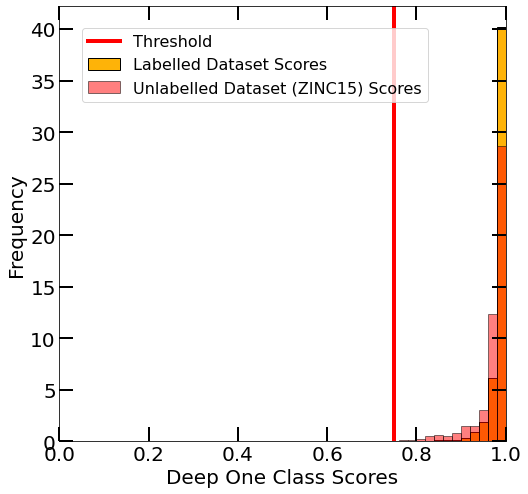

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(lab.train_score.values, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')
#_= plt.hist(validation.score, bins=150,density=True, ec='k',alpha=0.5, color='red', label='Paracetamol Validation Scores')
_= plt.hist(unlab_final.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset (ZINC15) Scores')
#_= plt.hist(unlab_final_drug.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Drug Subset Scores')
#_= plt.hist(val.train_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset Scores')
_ = plt.axvline(x=0.75, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
#major_ticks_x = np.arange(0, 1.001, 0.2)
#minor_ticks_x = np.arange(0,1.001, 0.1)
#major_ticks_y = np.arange(0, 6, 2)
#minor_ticks_y = np.arange(0, 6, 1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)

plt.legend(prop={'size': 16}, loc=[0.05, 0.78])
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/deep_scores_ histogram.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
# Paracetamol validation
paracet = score(deep_SVDD, paracetamol.iloc[:,:].values).cpu().detach().numpy()*-1
paracet1 = y_scaler1.transform(paracet.reshape(-1,1))
validation=pd.concat([pd.DataFrame(paracet1, columns=['score']), pd.DataFrame(par_label.values, columns=['color'])], axis=1)
val_sort = validation.sort_values(by='score', ascending=False)
val_sort

RuntimeError: ignored

In [ ]:
pd.concat([par_2.id,validation], axis=1).sort_values(by='score', ascending=False)

,id,score,color
30,Nicotinamide,1.000135,0
31,Isonicotinamide,1.000128,0
14,"1,4-diaminocyclohexane",0.997904,1
24,Theophylline,0.997878,1
15,Theobromine,0.997814,0
3,"4,4'-Bipyridine",0.997630,1
20,"N,N-dimethyl-piperazine",0.996995,1
23,Resorcinol,0.996966,0
4,"1,4-di-4-pyridyl-ethylene",0.996595,1
0,Caffeine,0.996409,0


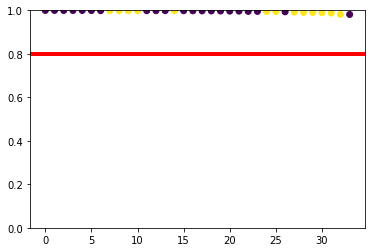

In [ ]:
x=np.arange(len(paracet1))
plt.scatter(x ,val_sort.score, c=val_sort.color)
plt.ylim(0,1)
plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)

In [ ]:
# Public data validation
pub = score(deep_SVDD, public.iloc[:,:].values).cpu().detach().numpy()*-1
pub1 = y_scaler1.transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(public_label.values, columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

Text(0.5, 1.0, 'Public data validation set')

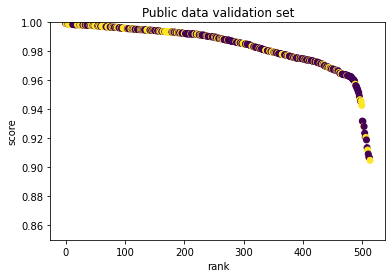

In [ ]:
x=np.arange(len(pub1))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color)
plt.ylim(0.85,1)
plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')
plt.title('Public data validation set')

Specificity :  0.375
Roc_auc_score :  0.5663659793814433
Recall_score :  0.7577319587628866


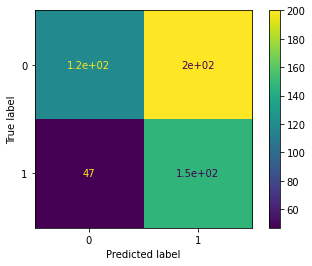

In [ ]:
# Public available
evaluate_public(0.98, pub_val_sort.score.values, pub_val_sort.color.values)

In [ ]:
# RC data validation 
rc = score(deep_SVDD, rc_data.iloc[:,:].values).cpu().detach().numpy()*-1
rc1 = y_scaler1.transform(rc.reshape(-1,1))
rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(rc_label.values, columns=['color'])], axis=1)
rc_val_sort = rc_validation.sort_values(by='score', ascending=False)

Text(0.5, 1.0, 'RC validation set')

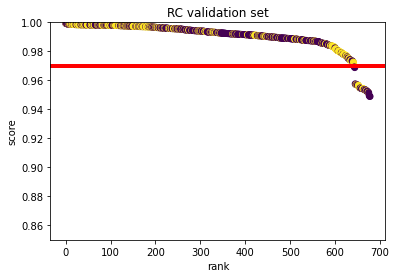

In [ ]:
# RC data
x=np.arange(len(rc1))
plt.scatter(x ,rc_val_sort.score, c=rc_val_sort.color)
plt.ylim(0.85,1)
plt.axhline(y=0.97, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')
plt.title('RC validation set')

Specificity :  0.058823529411764705
Roc_auc_score :  0.5055147058823529
Recall_score :  0.9522058823529411


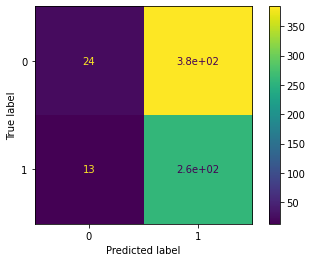

In [ ]:
# RC data
evaluate_public(0.97, rc_validation.score.values, rc_label.values)

In [ ]:
# Artemicin data

artem = score(deep_SVDD, artemicin.iloc[:,:].values).cpu().detach().numpy()*-1
artem1 = y_scaler1.transform(artem.reshape(-1,1))
artemicin_validation=pd.concat([pd.DataFrame(artem1, columns=['score']), pd.DataFrame(artemicin_label.values, columns=['color'])], axis=1)
artemicin_val_sort = artemicin_validation.sort_values(by='score', ascending=False)


Text(0.5, 1.0, 'Artemic validation set')

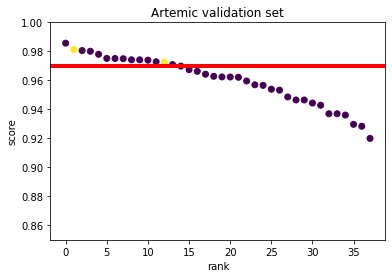

In [ ]:
x=np.arange(len(artem1))
plt.scatter(x ,artemicin_val_sort.score, c=artemicin_val_sort.color, label='cocrystal')
plt.ylim(0.85,1)
plt.axhline(y=0.97, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')

plt.title('Artemic validation set')

Specificity :  0.6666666666666666
Roc_auc_score :  0.8333333333333334
Recall_score :  1.0


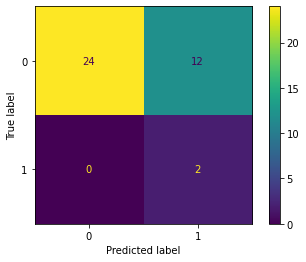

In [ ]:
# Public available
evaluate_public(0.97, artemicin_val_sort.score.values, artemicin_val_sort.color.values)

## Evaluation 

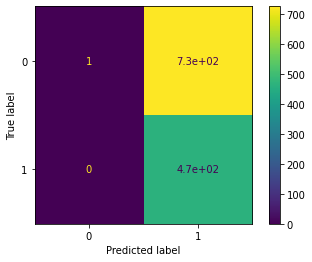

In [ ]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# assign 1 to pairs that score > 0.8 and 0 to pairs with score <0.8
#y_pred1 =[1 if i>=0.8 else 0 for i in val_sort.score.values]
y_pred2= [1 if i>=0.88 else 0 for i in rc_val_sort.score.values]
y_pred3  =[1 if i>=0.88 else 0 for i in pub_val_sort.score.values]

y_pred= y_pred2+y_pred3 #y_pred1+

# labels for known combinations
y_test1 = par_label.values
#y_pred=[1 if i>=0.8 else 0 for i in rc_val_sort.score.values]
y_test2 =rc_label.values
y_test3 =public_label.values

y_test = np.concatenate([y_test2, y_test3]) #y_test1,

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=(0,1)).plot()


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
y_pred=[1 if i>=0.99 else 0 for i in rc_val_sort.score.values]
y_test =rc_label.values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
specificity

0.16176470588235295

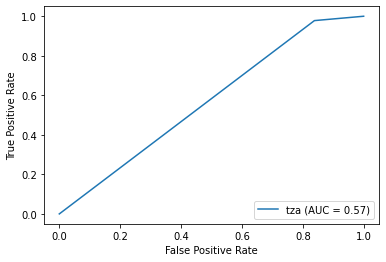

In [ ]:

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)#, pos_label=(0,1))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='tza').plot()


In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.9779411764705882

[0.4005891 1.       ]
[1. 0.]


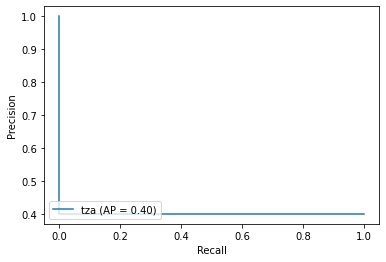

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

av_prec = average_precision_score(y_test, y_pred)

prec, recall, _ = precision_recall_curve(y_test, y_pred)
print(prec)
print(recall)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=av_prec,estimator_name='tza' ).plot()

## Shapley - Feature importance 

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 5.9MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489394 sha256=fef08e618610c7c808021dcf665d5405f48cb11a5edb1ba920bf0c1b0f7895ac
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [ ]:

class  CocryNet(nn.Module):
    def __init__(self, net, R, C):
      
        super().__init__()
        self.net = net
        self.R = torch.Tensor([R]).to("cuda")
        self.C = torch.Tensor([C]).to("cuda")

    def forward(self, x):
        #x = torch.FloatTensor(x).cpu().to(device)
        outputs = self.net(x)
        dist = torch.sum((outputs - self.C) ** 2, dim=1)
        scores = (dist - self.R ** 2)*-1
        lab = score(deep_SVDD, labelled.iloc[:,:].values).cpu().detach().numpy()*-1 
        M= lab.max()
        m= lab.min()
        scores = (scores - m)/(M-m)
        return scores.unsqueeze(1)
shapNet = CocryNet(deep_SVDD.net, deep_SVDD.R, deep_SVDD.c)

In [ ]:
# Add the '_1' and '_2' at the end of each descriptor to denote the possition of the molecule in the vector
df11=df2.iloc[:,:]
labels1 = df11.rename(columns=lambda x: f"{x}_1")
labels2 = df11.rename(columns=lambda x: f"{x}_2")
dataset1_labels = labels1.columns.values
dataset2_labels = labels2.columns.values

cols = np.concatenate((dataset1_labels, dataset2_labels))
len(cols)


54

In [ ]:
# Interpretability of the whole bidirectional dataset
import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(paracetamol.iloc[:, :].values).to(device)  #df #negatives_data
model = shapNet#.to(device)

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#e = shap.KernelExplainer(model, background)
shap_values = e.shap_values(background, rseed=1, ranked_outputs=10)

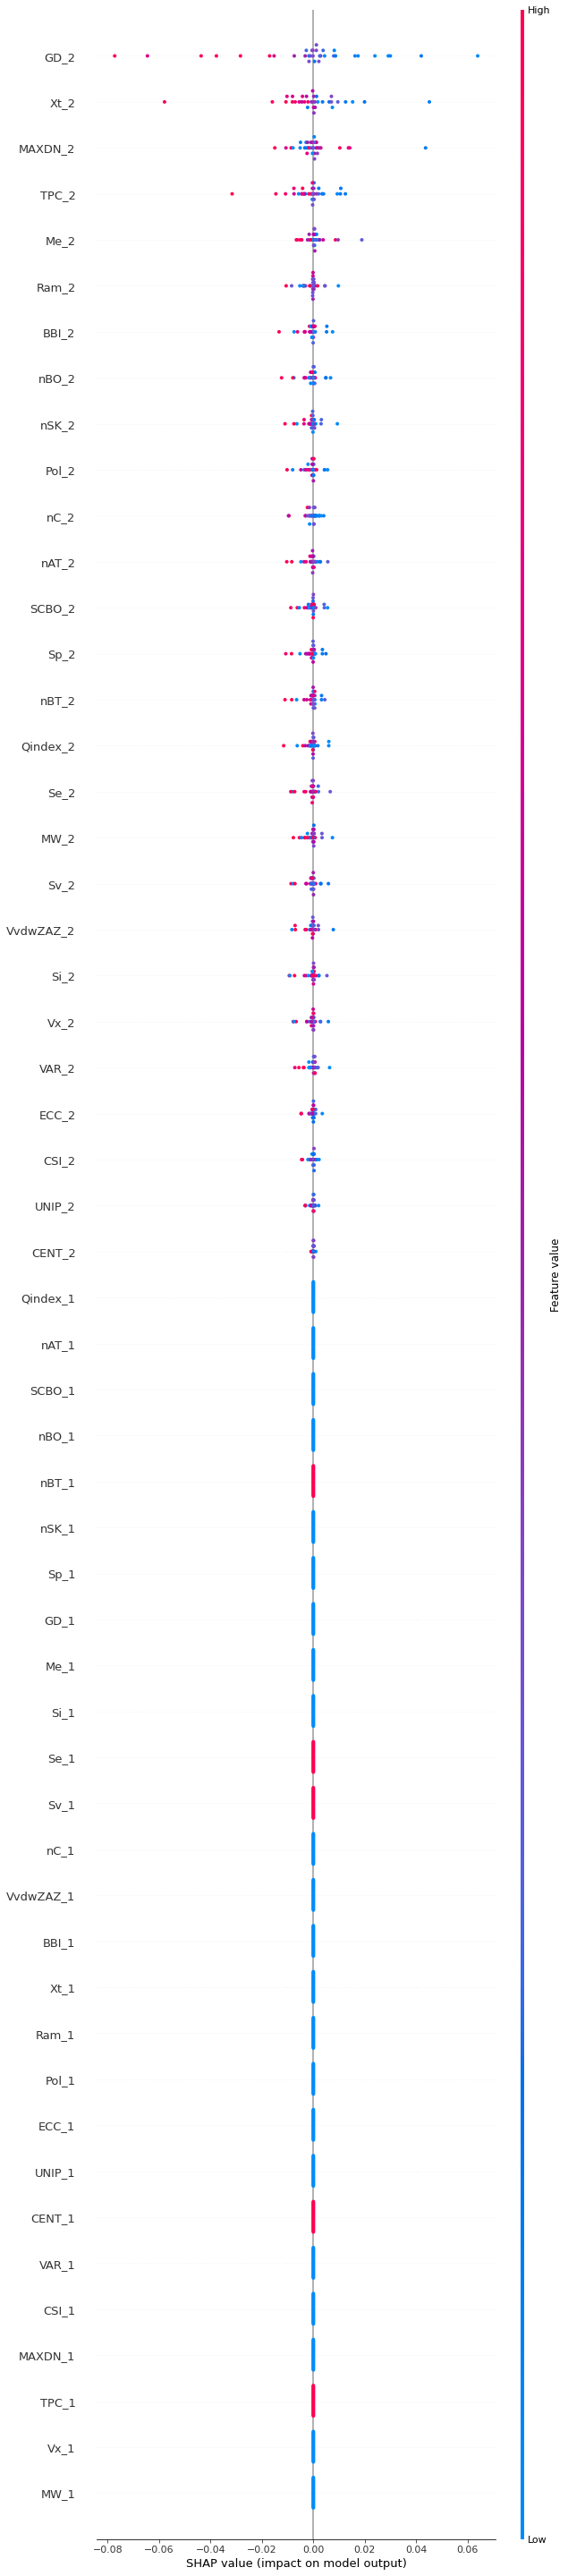

In [ ]:
# Plot the most important features 

X = pd.DataFrame(paracetamol.iloc[:, :].values, columns=cols)  #negatives_data

shap.summary_plot(shap_values[:], X ,  color_bar=True, plot_size=(10,52), layered_violin_max_num_bins=30, class_names=None, max_display=60,  show=False)

#plt.savefig('shap_lab.svg')

In [ ]:
pd.concat([par_2.id,validation], axis=1).sort_values(by='score', ascending=False)

,id,score,color
32,"3S-cis-3,6-dimethyl-1,4-dioane-2,5-dione",0.999685,0
23,Resorcinol,0.999652,0
30,Nicotinamide,0.999507,0
31,Isonicotinamide,0.999500,0
12,Benzoic acid,0.999486,0
11,"2,5-dihydroxybenzoic acid",0.999090,0
25,Ascorbic acid,0.998625,0
4,"1,4-di-4-pyridyl-ethylene",0.998625,1
2,"1,2-bis-4-pyridyl-ethane",0.998624,1
24,Theophylline,0.998624,1


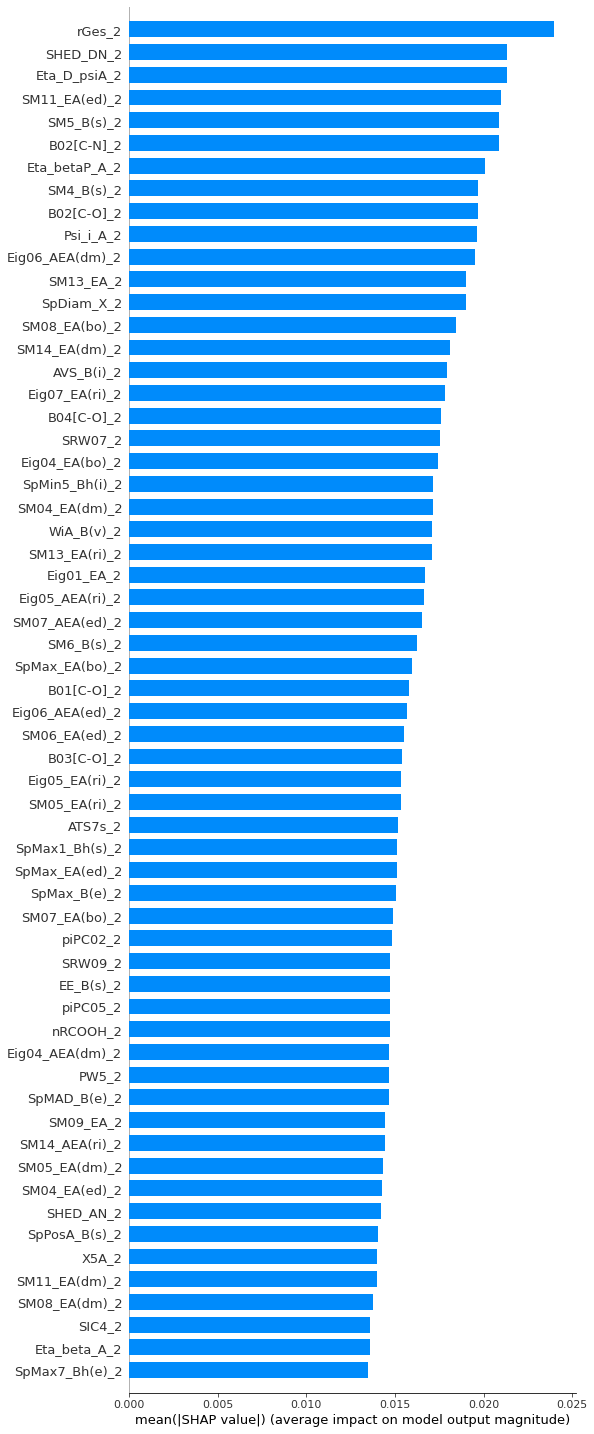

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',max_display=60)

In [ ]:
df =df.drop(columns=['SpMax7_Bh(i)', 'ATS8m', 'B01[C-N]', 'Ro5', 'SpMax2_Bh(m)', 'Eig09_AEA(ri)', 'SpMax_B(m)', 'B03[C-O]', 'ATS8s', 'Eig13_AEA(ed)',
                 'SM4_Dz(v)', 'piPC02', 'B04[C-N]', 'Eig10_EA(ri)', 'cRo5', 'SM13_AEA(bo)', 'SpMin8_Bh(v)', 'SM2_Dz(i)', 'SpPosA_B(s)',
                 'SpMin5_Bh(p)', 'Eig15_AEA(ed)', 'SpMaxA_AEA(ri)', 'B02[C-N]', 'SM05_AEA(ed)', 'SpMin4_Bh(s)', 'SIC1', 'SpMin8_Bh(s)', 'SpMin8_Bh(v)',
                 'SpMin5_Bh(v)', 'Eig12_AEA(ri)', 'piPC06'])

In [ ]:
sh=pd.DataFrame(shap_values, columns=X.columns.values)
sh

,MW_1,AMW_1,Sv_1,Se_1,Sp_1,Si_1,Mv_1,Me_1,Mp_1,Mi_1,GD_1,nAT_1,nSK_1,nTA_1,nBT_1,nBO_1,nBM_1,SCBO_1,RBN_1,RBF_1,nDB_1,nTB_1,nAB_1,nH_1,nC_1,nN_1,nO_1,nP_1,nS_1,nF_1,nCL_1,nBR_1,nI_1,nB_1,nHM_1,nHet_1,nX_1,H%_1,C%_1,N%_1,...,ALOGP_2,ALOGP2_2,SAtot_2,SAacc_2,SAdon_2,Vx_2,VvdwMG_2,VvdwZAZ_2,PDI_2,BLTF96_2,BLTD48_2,BLTA96_2,Ro5_2,cRo5_2,DLS_01_2,DLS_02_2,DLS_03_2,DLS_04_2,DLS_05_2,DLS_06_2,DLS_07_2,DLS_cons_2,LLS_01_2,LLS_02_2,CMC-80_2,CMC-50_2,Inflammat-80_2,Inflammat-50_2,Depressant-80_2,Depressant-50_2,Psychotic-80_2,Psychotic-50_2,Hypertens-80_2,Hypertens-50_2,Hypnotic-80_2,Hypnotic-50_2,Neoplastic-80_2,Neoplastic-50_2,Infective-80_2,Infective-50_2
0,-0.001010,-0.000515,0.008685,0.000624,0.005205,-0.001891,-0.001094,-0.001569,0.011344,0.001166,-0.005937,0.003127,0.000053,0.000432,0.001309,-0.002502,-0.000836,-0.000434,0.000323,-0.009146,-0.001074,0.000682,-0.001704,0.006943,-0.008037,0.003325,-0.001878,0.0,-0.000849,-0.001236,0.000447,0.000187,0.002500,0.0,-0.001805,0.002334,0.015722,-0.001742,0.015989,0.000332,...,0.007080,0.001496,-0.006628,0.002022,0.006296,0.011793,-0.000006,0.001388,0.002794,-0.006404,0.016145,-0.020067,0.018502,0.021435,-0.005322,-0.004821,0.004782,0.003740,-0.000585,0.007209,0.012453,-0.000417,-0.002309,0.006635,-0.004126,-0.001268,0.002063,0.000448,0.000952,0.000373,0.000986,0.000572,0.002097,0.001884,0.000652,0.000472,0.010658,0.001056,-0.002600,0.001598
1,-0.002358,0.001595,0.002025,0.002257,0.005690,-0.000527,-0.002727,0.000245,0.012870,-0.001810,-0.007727,-0.001876,0.000865,-0.000209,-0.000369,-0.000150,0.001678,-0.002701,0.000617,-0.019350,-0.001476,0.000432,-0.002317,0.004203,-0.007709,0.002224,-0.001643,0.0,0.000306,-0.001078,0.000017,0.000059,-0.000804,0.0,-0.000076,0.000176,0.004309,-0.001741,0.022990,-0.000157,...,0.003655,0.008822,-0.010007,-0.000337,-0.008490,0.019826,-0.001556,0.008155,0.003083,0.001247,0.017683,-0.025691,0.023272,0.017507,-0.000556,-0.003994,0.005811,0.002982,-0.003898,0.001176,0.010717,-0.001012,0.010217,0.013566,0.006455,-0.000685,-0.000490,0.000225,0.000463,0.000000,0.000549,0.000074,0.002547,0.000000,-0.001336,-0.000123,0.004060,0.001068,0.004342,0.001720
2,-0.000149,0.004186,0.002015,0.001830,0.004148,-0.000179,-0.004824,-0.002495,0.012086,0.000245,-0.007850,-0.001209,0.000258,0.000218,-0.001504,-0.000278,0.001371,-0.002001,0.000499,-0.012750,-0.002304,0.002748,-0.001098,0.004020,-0.005311,0.000824,-0.001585,0.0,0.000352,-0.001519,-0.000120,-0.000013,0.002303,0.0,0.000258,-0.000102,0.002930,-0.001211,0.017256,-0.003666,...,0.001403,0.000211,-0.005026,-0.001406,-0.007250,0.005436,0.000161,0.002416,0.000420,0.003454,0.009726,-0.013589,0.007764,0.007059,0.001546,-0.002850,0.001333,0.000387,-0.000107,0.001605,0.001834,-0.001058,0.006148,0.004467,0.002330,-0.000519,0.000313,0.000045,0.001069,0.000000,0.000994,0.000000,0.002279,-0.000217,-0.000965,0.000137,0.002861,0.000008,0.006391,0.001907
3,-0.002188,0.000104,0.005328,0.000450,0.006471,-0.002543,0.000269,-0.000428,0.001353,0.001490,-0.001012,-0.000079,-0.001454,-0.001468,-0.000998,-0.001594,-0.000892,0.000358,-0.001810,0.006098,0.002226,0.002367,0.001209,0.003940,0.000584,0.001784,0.000627,0.0,0.000774,0.000226,0.000161,-0.000155,-0.000071,0.0,-0.001572,-0.000958,0.003903,0.000571,-0.003385,0.000413,...,0.003343,0.001679,-0.002905,0.000188,0.009602,0.003881,-0.001834,0.003735,0.003223,0.002565,0.016174,-0.012808,0.013518,0.012274,0.002686,0.005622,0.003544,0.005254,-0.000093,0.000548,0.003166,0.000414,-0.000573,0.009144,0.011646,0.000580,0.001562,0.000417,-0.000734,0.000253,0.000447,0.000000,0.002266,0.000893,0.001735,0.000056,0.003281,0.000913,-0.000867,0.000963
4,0.001184,0.003327,0.001549,-0.000175,0.002309,0.001029,-0.000197,-0.004382,0.000348,-0.000531,-0.004226,0.000298,-0.000112,0.001150,0.000084,-0.002291,-0.000196,0.000616,-0.002108,0.004533,0.006630,-0.000953,-0.000382,0.000593,-0.000446,0.000319,-0.001752,0.0,0.000737,0.000118,-0.000397,-0.000163,0.002995,0.0,0.000077,-0.000872,0.003946,-0.011082,0.001386,0.0

In [ ]:
# retrieve descriptors with a physical meaning based on correlations between descriptors
shap_values[:].shape
pd.concat([X,pd.DataFrame(shap_values) ], axis=1)


,MW_1,AMW_1,Sv_1,Se_1,Sp_1,Si_1,Mv_1,Me_1,Mp_1,Mi_1,GD_1,nAT_1,nSK_1,nTA_1,nBT_1,nBO_1,nBM_1,SCBO_1,RBN_1,RBF_1,nDB_1,nTB_1,nAB_1,nH_1,nC_1,nN_1,nO_1,nP_1,nS_1,nF_1,nCL_1,nBR_1,nI_1,nB_1,nHM_1,nHet_1,nX_1,H%_1,C%_1,N%_1,...,7730,7731,7732,7733,7734,7735,7736,7737,7738,7739,7740,7741,7742,7743,7744,7745,7746,7747,7748,7749,7750,7751,7752,7753,7754,7755,7756,7757,7758,7759,7760,7761,7762,7763,7764,7765,7766,7767,7768,7769
0,0.022494,0.101185,0.019118,0.018923,0.014245,0.020672,0.212555,0.411539,0.045280,0.454955,0.554196,0.019704,0.025862,0.12500,0.018519,0.022222,0.019048,0.022346,0.066667,0.60000,0.153846,0.000,0.000000,0.035714,0.019802,0.000000,0.114286,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.114286,0.00,0.545455,0.200000,0.000000,...,0.007080,0.001496,-0.006628,0.002022,0.006296,0.011793,-0.000006,0.001388,0.002794,-0.006404,0.016145,-0.020067,0.018502,0.021435,-0.005322,-0.004821,0.004782,0.003740,-0.000585,0.007209,0.012453,-0.000417,-0.002309,0.006635,-0.004126,-0.001268,0.002063,0.000448,0.000952,0.000373,0.000986,0.000572,0.002097,0.001884,0.000652,0.000472,0.010658,0.001056,-0.002600,0.001598
1,0.022494,0.101185,0.019118,0.018923,0.014245,0.020672,0.212555,0.411539,0.045280,0.454955,0.554196,0.019704,0.025862,0.12500,0.018519,0.022222,0.019048,0.022346,0.066667,0.60000,0.153846,0.000,0.000000,0.035714,0.019802,0.000000,0.114286,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.114286,0.00,0.545455,0.200000,0.000000,...,0.003655,0.008822,-0.010007,-0.000337,-0.008490,0.019826,-0.001556,0.008155,0.003083,0.001247,0.017683,-0.025691,0.023272,0.017507,-0.000556,-0.003994,0.005811,0.002982,-0.003898,0.001176,0.010717,-0.001012,0.010217,0.013566,0.006455,-0.000685,-0.000490,0.000225,0.000463,0.000000,0.000549,0.000074,0.002547,0.000000,-0.001336,-0.000123,0.004060,0.001068,0.004342,0.001720
2,0.022494,0.101185,0.019118,0.018923,0.014245,0.020672,0.212555,0.411539,0.045280,0.454955,0.554196,0.019704,0.025862,0.12500,0.018519,0.022222,0.019048,0.022346,0.066667,0.60000,0.153846,0.000,0.000000,0.035714,0.019802,0.000000,0.114286,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.114286,0.00,0.545455,0.200000,0.000000,...,0.001403,0.000211,-0.005026,-0.001406,-0.007250,0.005436,0.000161,0.002416,0.000420,0.003454,0.009726,-0.013589,0.007764,0.007059,0.001546,-0.002850,0.001333,0.000387,-0.000107,0.001605,0.001834,-0.001058,0.006148,0.004467,0.002330,-0.000519,0.000313,0.000045,0.001069,0.000000,0.000994,0.000000,0.002279,-0.000217,-0.000965,0.000137,0.002861,0.000008,0.006391,0.001907
3,0.022519,0.084204,0.031170,0.018975,0.030637,0.023868,0.342972,0.133802,0.191074,0.352985,0.554196,0.024631,0.034483,0.03125,0.027778,0.037037,0.066667,0.050279,0.000000,0.00000,0.000000,0.125,0.058252,0.035714,0.049505,0.111111,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.057143,0.00,0.500000,0.450000,0.261905,...,0.003343,0.001679,-0.002905,0.000188,0.009602,0.003881,-0.001834,0.003735,0.003223,0.002565,0.016174,-0.012808,0.013518,0.012274,0.002686,0.005622,0.003544,0.005254,-0.000093,0.000548,0.003166,0.000414,-0.000573,0.009144,0.011646,0.000580,0.001562,0.000417,-0.000734,0.000253,0.000447,0.000000,0.002266,0.000893,0.001735,0.000056,0.003281,0.000913,-0.000867,0.000963
4,0.024078,0.032833,0.042509,0.040975,0.045995,0.048564,0.162887,0.045912,0.114712,0.381056,0.554196,0.049261,0.034483,0.06250,0.050926,0.037037,0.057143,0.039106,0.000000,0.00000,0.000000,0.000,0.058252,0.080357,0.059406,0.055556,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.028571,0.00,0.794118,0.352941,0.092437,...,0.000863,0.000456,0.000264,-0.000386,0.001986,0.005703,0.003920,-0.001240,0.002919,0.010279,0.006225,-0.006336,0.003967,0.003166,-0.001034,-0.006824,-0.003034,0.005599,-0.005333,0.000075,0.000280,-0.001806,-0.004732,0.003042,-0.005926,0.000356,0.000247,0.000359,0.000474,-0.000247,-0.000032,0.000000,0.003503,0.000606,0.006588,0.000238,0.002431,0.002010,0.004991,-0.000182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,